## (Exercises) Graph Neural Networks with PyTorch

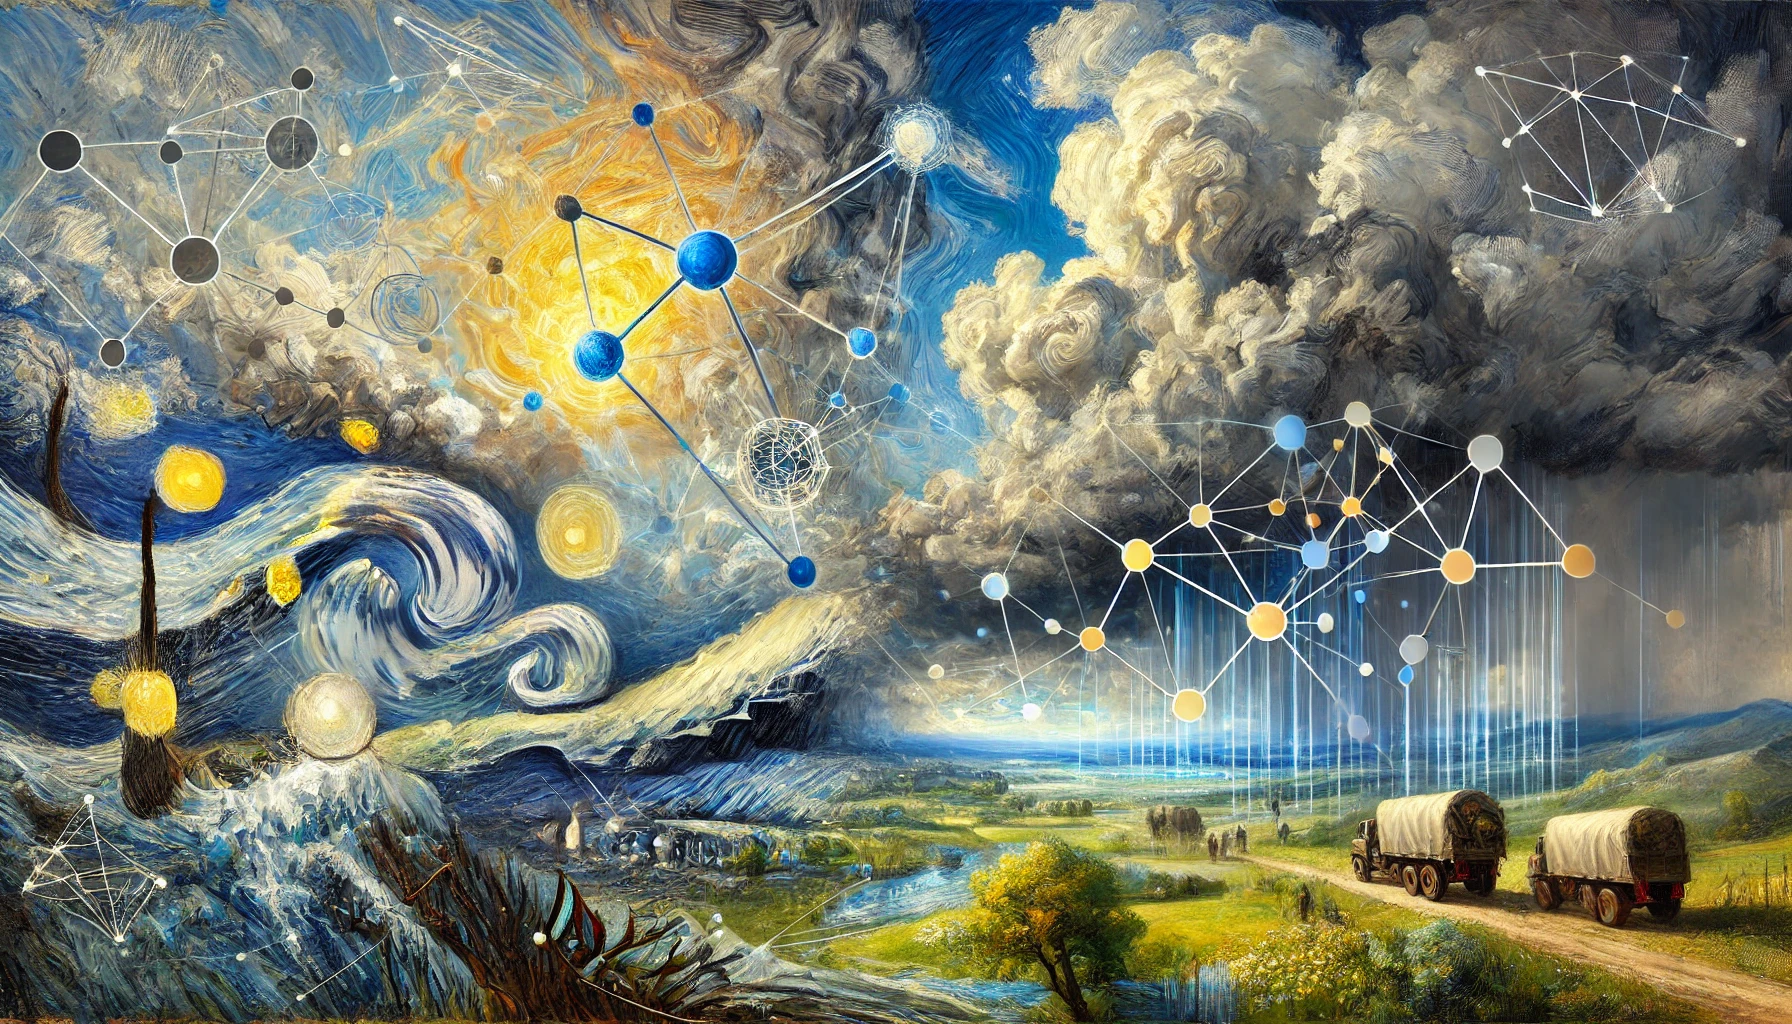

*Figure: An AI artwork on GNN and weather forcasting created by GPT4, 2024*

This notebook is designed to be run on Google Colab and we highly recommend clicking on the Google Colab badge to proceed.

Aiming at covering the knowledge of Labonne's Chapters 01 + 02, this jupyter notebook builds on the related colab assignments in [*CS224W: Machine Learning with Graphs*](https://web.stanford.edu/class/cs224w/index.html), originally offered by Prof. Jure and his team Stanford University.

We hope the AI artwork inspires you to familiarize yourself with the basic concepts of graph mining and Graph Neural Networks through this notebook. All of them are mainly implemented through two libraries, [*NetworkX*](https://networkx.org/documentation/stable/) and [*PyTorch Geometric*](https://pytorch-geometric.readthedocs.io/en/latest/). In this notebook, we will write a full pipeline for **learning Node Embeddings** and introducing the **Graph Neural Networks**. We will go through the following 4 steps.

1.  To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). Then we will offer the basic tutorial for **NetworkX** before exploring multiple graph statistics.

2.  With the help of the **PyTorch Geometric** tutorial, we will then work together to transform the graph structure into a PyTorch tensor, enabling machine learning applications.

3.  And we will finish the first learning algorithm on graphs: a **node embedding** model. For simplicity, our model here is simpler than classical algorithms applied in the research, such as DeepWalk or node2vec. But it's still rewarding and challenging, as we will write it from scratch via PyTorch.

4.  Finally, we will implement one of the simplest GNN operators, the **Graph Convolutional Networks** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)). We hope you can use this 3-layers GCN to learn embeddings that will be useful to classify each node into its community within the Karate Club Network.

### Graph Basics
To start, we will load a classic graph in network science, the [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). We will explore multiple graph statistics for that graph.

#### NetworkX Tutorial

NetworkX is one of the most frequently used Python packages to create, manipulate, and mine graphs.

This tutorial is adapted from https://colab.research.google.com/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/libraries/NetworkX.ipynb#scrollTo=zA1OO6huHeV6

You can explore more NetworkX functions through its [documentation](https://networkx.org/documentation/stable/).

**Setup**

In [1]:
# Upgrade packages
!pip install --upgrade scipy networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [3]:
# Import the NetworkX package
import networkx as nx

**Graph**

NetworkX provides several classes to store different types of graphs, such as directed and undirected graph. It also provides classes to create multigraphs (both directed and undirected).


In [4]:
# Create an undirected graph G
G = nx.Graph()
print(G.is_directed())

# Create a directed graph H
H = nx.DiGraph()
print(H.is_directed())

# Add graph level attribute
G.graph["Name"] = "Bar"
print(G.graph)

False
True
{'Name': 'Bar'}


**Node**

Nodes (with attributes) can be easily added to NetworkX graphs.

In [5]:
# Add one node with node level attributes
G.add_node(0, feature=5, label=0)

# Get attributes of the node 0
node_0_attr = G.nodes[0]
print("Node 0 has the attributes {}".format(node_0_attr))

Node 0 has the attributes {'feature': 5, 'label': 0}


In [6]:
G.nodes(data=True)

NodeDataView({0: {'feature': 5, 'label': 0}})

In [7]:
# Add multiple nodes with attributes
G.add_nodes_from([
  (1, {"feature": 1, "label": 1}),
  (2, {"feature": 2, "label": 2})
]) #(node, attrdict)

# Loop through all the nodes
# Set data=True will return node attributes
for node in G.nodes(data=True):
  print(node)

# Get number of nodes
num_nodes = G.number_of_nodes()
print("G has {} nodes".format(num_nodes))

(0, {'feature': 5, 'label': 0})
(1, {'feature': 1, 'label': 1})
(2, {'feature': 2, 'label': 2})
G has 3 nodes


**Edge**

Similar to nodes, edges (with attributes) can also be easily added to NetworkX graphs.

In [8]:
# Add one edge with edge weight 0.5
G.add_edge(0, 1, weight=0.5)

# Get attributes of the edge (0, 1)
edge_0_1_attr = G.edges[(0, 1)]
print("Edge (0, 1) has the attributes {}".format(edge_0_1_attr))

Edge (0, 1) has the attributes {'weight': 0.5}


In [9]:
# Add multiple edges with edge weights
G.add_edges_from([
  (1, 2, {"weight": 0.3}),
  (2, 0, {"weight": 0.1})
])

# Loop through all the edges
# Here there is no data=True, so only the edge will be returned
for edge in G.edges():
  print(edge)

# Get number of edges
num_edges = G.number_of_edges()
print("G has {} edges".format(num_edges))

(0, 1)
(0, 2)
(1, 2)
G has 3 edges


**Graph Visualization**

NetworkX also provides tooling to conventiently visualize graphs.

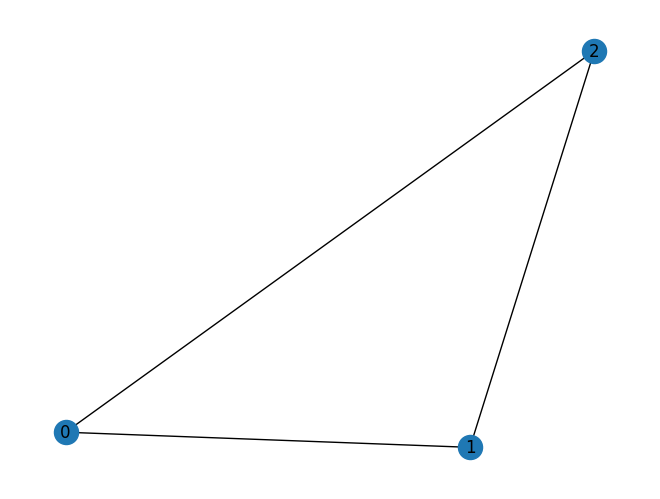

In [10]:
# Draw the graph
nx.draw(G, with_labels = True)

**Node Degree and Neighbor**

In [11]:
node_id = 1

# Degree of node 1
print("Node {} has degree {}".format(node_id, G.degree[node_id]))

# Get neighbor of node 1
for neighbor in G.neighbors(node_id):
  print("Node {} has neighbor {}".format(node_id, neighbor))

Node 1 has degree 2
Node 1 has neighbor 0
Node 1 has neighbor 2


**Other Functionalities**

NetworkX also provides plenty of useful methods to study graphs. Here is an example to get [PageRank](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html#networkx.algorithms.link_analysis.pagerank_alg.pagerank) of nodes.

{0: 0.17857162031103999,
 1: 0.32142837968896,
 2: 0.32142837968896,
 3: 0.17857162031103999}

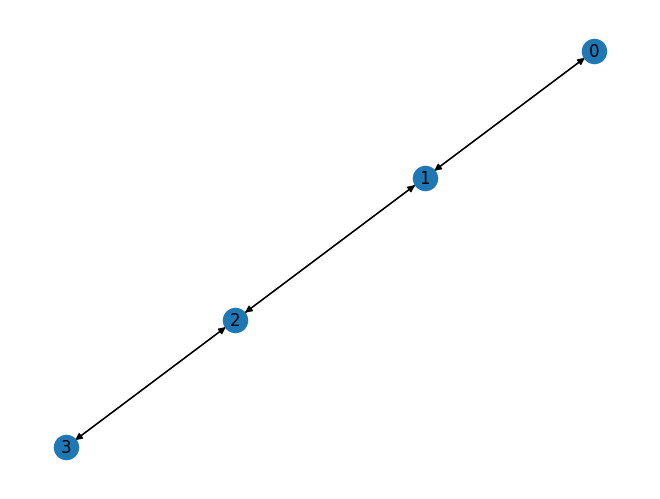

In [12]:
num_nodes = 4

# Create a new path like graph and change it to a directed graph
G = nx.DiGraph(nx.path_graph(num_nodes))
nx.draw(G, with_labels = True)

# Get the PageRank
pr = nx.pagerank(G, alpha=0.8)
pr

#### Exercise 1

**Zachary's karate club network**

The [Karate Club Network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a graph which describes a social network of 34 members of a karate club and documents links between members who interacted outside the club.

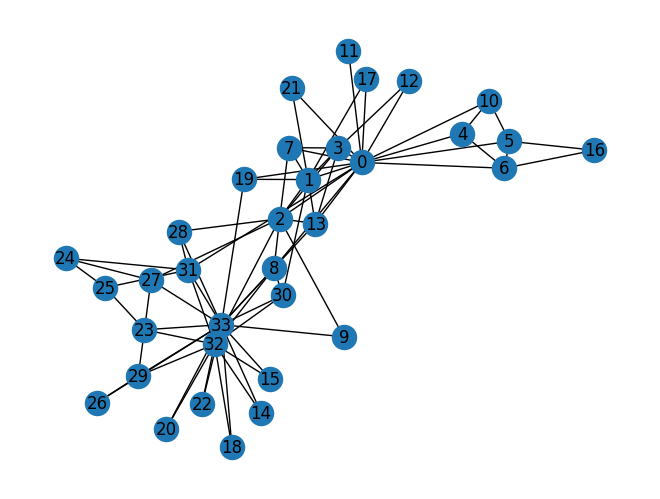

In [13]:
# Find the karate club network from the NetworkX
G_karate = nx.karate_club_graph()

# G is an undirected graph
type(G_karate)

# Visualize the graph
nx.draw(G_karate, with_labels = True)

**Question 1: What is the average degree of the karate club network?**

In [14]:
def average_degree(num_edges, num_nodes):
  # TODO: Implement this function that takes number of edges
  # and number of nodes, and returns the average node degree of
  # the graph. Round the result to nearest integer (for example
  # 3.3 will be rounded to 3 and 3.7 will be rounded to 4)

  avg_degree = 0

  ############# Your code here ############
  #########################################
  avg_degree = round((2 * num_edges) / num_nodes)


  return avg_degree

In [15]:
num_edges = G_karate.number_of_edges()
num_nodes = G_karate.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


**Question 2: What is the average clustering coefficient of the karate club network?**

In [16]:
def average_clustering_coefficient(G_karate):
  # TODO: Implement this function that takes a nx.Graph
  # and returns the average clustering coefficient. Round
  # the result to 2 decimal places (for example 3.333 will
  # be rounded to 3.33 and 3.7571 will be rounded to 3.76)

  avg_cluster_coef = 0

  ############# Your code here ############
  ## Note:
  ## 1: Please use the appropriate NetworkX clustering function
  #########################################
  avg_cluster_coef = round(nx.average_clustering(G_karate), 2)

  return avg_cluster_coef

In [17]:
avg_cluster_coef = average_clustering_coefficient(G_karate)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.57


**Question 3: What is the PageRank value for node 0 (node with id 0) after one PageRank iteration?**

Page Rank measures importance of nodes in a graph using the link structure of the web. A “vote” from an important page is worth more. Specifically, if  a page $i$ with importance $r_i$ has $d_i$ out-links, then each link gets $\frac{r_i}{d_i}$ votes. Thus, the importance of a Page $j$, represented as $r_j$ is the sum of the votes on its in links.
$$r_j = \sum_{i \rightarrow j} \frac{r_i}{d_i},$$
where $d_i$ is the out degree of node $i$.

The PageRank algorithm (used by Google) outputs a probability distribution which represent the likelihood of a random surfer clicking on links will arrive at any particular page. At each time step, the random surfer has two options
- With prob. $\beta$, follow a link at random
- With prob. $1- \beta$, jump to a random page

Thus, the importance of a particular page is calculated with the following PageRank equation:
 $$r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$$

Please complete the code block by implementing the above PageRank equation for node 0.

*Note: You can refer to more information from the [Stanford's slides](http://snap.stanford.edu/class/cs224w-2020/slides/04-pagerank.pdf)*


In [33]:
def one_iter_pagerank(G_karate, beta, r0, node_id):

  # TODO: Implement this function that takes a nx.Graph, beta, r0 and node id.
  # The return value r1 is the one interation PageRank value for the input node.
  # Please round r1 to 2 decimal places.



  ############# Your code here ############
  ## Note:
  ## 1: You should not use nx.pagerank
  #########################################
  r1 = 1 - beta
  for neighbor in G_karate.neighbors(node_id):
        degree = G_karate.degree(neighbor)
        if degree > 0:  # Avoid division by zero
            r1 += beta * (r0 / degree)

    # Round to 2 decimal places
  r1 = round(r1, 2)

  return r1

In [34]:
beta = 0.8
r0 = 1 / G_karate.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G_karate, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.32


**Question 4: What is the (raw) closeness centrality for the karate club network node 5?**

The equation for closeness centrality is $c(v) = \frac{1}{\sum_{u \neq v}\text{shortest path length between } u \text{ and } v}$

In [38]:
def closeness_centrality(G_karate, node=5):
  # TODO: Implement the function that calculates closeness centrality
  # for a node in karate club network. G is the input karate club
  # network and node is the node id in the graph. Please round the
  # closeness centrality result to 2 decimal places.

  closeness = 0

  ## Note:
  ## 1: You can use networkx closeness centrality function.
  ## 2: Notice that networkx closeness centrality returns the normalized
  ## closeness directly, which is different from the raw (unnormalized)
  ## one that we learned in the lecture.
  #########################################

  path_lengths = nx.shortest_path_length(G_karate, source=node)
  total_distance = sum(path_lengths.values()) - path_lengths[node]
  closeness = 1 / total_distance if total_distance > 0 else 0
  closeness = round(closeness, 2)

  return closeness

In [39]:
node = 5
closeness = closeness_centrality(G_karate, node=node)
print("The node 5 has closeness centrality {}".format(closeness))

The node 5 has closeness centrality 0.01


### Graph to Tensor

We will then work together to transform the graph $G$ into a PyTorch tensor, so that we can perform machine learning over the graph.

#### PyTorch Geometric Tutorial

PyTorch Geometric (PyG) is an extension library for PyTorch. It provides useful primitives to develop Graph Deep Learning models, including various graph neural network layers and a large number of benchmark datasets.

Don't worry if you don't understand some concepts such as `GCNConv`, as it may not be immediately useful depending on your exact objectives.

This tutorial is adapted from https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=ci-LpZWhRJoI

You can explore more PyG functions through its [documentation](https://pytorch-geometric.readthedocs.io/en/latest/).


In [40]:
import torch

print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 2.5.1+cu121


**Installing dependencies**

The installation of PyG on Colab can be a little bit tricky. Execute the cell below -- in case of issues, more information can be found on the [PyG's installation page](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html).

_Note: This cell might take a while (up to ~30 minutes) to run_

In [41]:
# Install torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.8 MB/s eta 0:00:00


**PyTorch tensor basics**

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.

We can generate PyTorch tensor with all zeros, ones or random values.

In [42]:
# Generate 3 x 4 tensor with all ones
ones = torch.ones(3, 4)
print(ones)

# Generate 3 x 4 tensor with all zeros
zeros = torch.zeros(3, 4)
print(zeros)

# Generate 3 x 4 tensor with random values on the interval [0, 1)
random_tensor = torch.rand(3, 4)
print(random_tensor)

# Get the shape of the tensor
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.8118, 0.8464, 0.0685, 0.6754],
        [0.2431, 0.4664, 0.8188, 0.6519],
        [0.2273, 0.3209, 0.8234, 0.8278]])
torch.Size([3, 4])


PyTorch tensor contains elements for a single data type, the `dtype`.

In [43]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


**Dataset**

Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), let's dive into the world of GNNs by looking at a simple graph-structured and previous example that we used, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). Here, we are interested in detecting communities that arise from the member's interaction.

PyTorch Geometric provides an easy access to the dataset via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) subpackage:

In [44]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


After initializing the [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) dataset, we first can inspect some of its properties.
For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club).
Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

Let's now look at the underlying graph in more detail:

In [45]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [46]:
data.edge_index.T

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

**Data**

Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.
We can print the data object anytime via `print(data)` to receive a short summary about its attributes and their shapes:

In [47]:
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


We can see that this `data` object holds 4 attributes:
(1) The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
PyG further refers to (2) **node features** as `x` (each of the 34 nodes is assigned a 34-dim feature vector), and to (3) **node labels** as `y` (each node is assigned to exactly one class).
(4) There also exists an additional attribute called `train_mask`, which describes for which nodes we already know their community assigments.
In total, we are only aware of the ground-truth labels of 4 nodes (one for each community), and the task is to infer the community assignment for the remaining nodes.

The `data` object also provides some **utility functions** to infer some basic properties of the underlying graph.
For example, we can easily infer whether there exists isolated nodes in the graph (*i.e.* there exists no edge to any node), whether the graph contains self-loops (*i.e.*, $(v, v) \in \mathbb{E}$), or whether the graph is undirected (*i.e.*, for each edge $(v, w) \in \mathbb{E}$ there also exists the edge $(w, v) \in \mathbb{E}$).

**Edge Index**

Next we'll print the `edge_index` of our graph:

In [48]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

By printing `edge_index`, we can further understand how PyG represents graph connectivity internally.
We can see that for each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathbb{V}| \times |\mathbb{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

We can further visualize the graph by converting it to the `networkx` library format, which implements, in addition to graph manipulation functionalities, powerful tools for visualization:

In [49]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

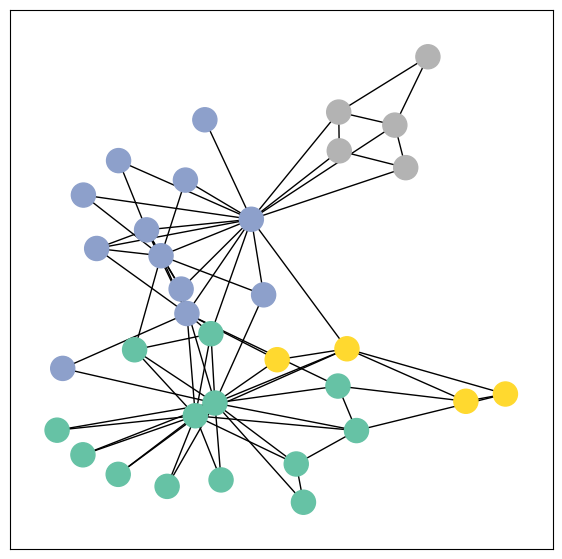

In [50]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

#### Exercise 2

**Question 5: Get the edge list of the karate club network and transform it into `torch.LongTensor`. What is the `torch.sum` value of `pos_edge_index` tensor?**

In [51]:
def graph_to_edge_list(G_karate):
  # TODO: Implement the function that returns the edge list of
  # an nx.Graph. The returned edge_list should be a list of tuples
  # where each tuple is a tuple representing an edge connected
  # by two nodes.

  edge_list = []

  ############# Your code here ############
  #########################################
  for edge in G_karate.edges():
    edge_list.append(edge)

  return edge_list

def edge_list_to_tensor(edge_list):
  # TODO: Implement the function that transforms the edge_list to
  # tensor. The input edge_list is a list of tuples and the resulting
  # tensor should have the shape [2, len(edge_list)].

  edge_index = torch.tensor([])

  ############# Your code here ############
  #########################################
  edge_index = torch.tensor(edge_list).T

  return edge_index

pos_edge_list = graph_to_edge_list(G_karate)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


**Question 6: Please implement following function that samples negative edges. Then answer which edges (edge_1 to edge_5) are the negative edges in the karate club network?**

"Negative" edges refer to the edges/links that do not exist in the graph. The term "negative" is borrowed from "negative sampling" in link prediction. It has nothing to do with the edge weights.

For example, given an edge (src, dst), you should check that neither (src, dst) nor (dst, src) are edges in the Graph. If these hold true, then it is a negative edge.

In [52]:
import random

def sample_negative_edges(G_karate, num_neg_samples):
  # TODO: Implement the function that returns a list of negative edges.
  # The number of sampled negative edges is num_neg_samples. You do not
  # need to consider the corner case when the number of possible negative edges
  # is less than num_neg_samples. It should be ok as long as your implementation
  # works on the karate club network. In this implementation, self loops should
  # not be considered as either a positive or negative edge. Also, notice that
  # the karate club network is an undirected graph, if (0, 1) is a positive
  # edge, do you think (1, 0) can be a negative one?

  neg_edge_list = []

  ############# Your code here ############
  #########################################
  while len(neg_edge_list) < num_neg_samples:
    src = random.randint(0, G_karate.number_of_nodes() - 1)
    dst = random.randint(0, G_karate.number_of_nodes() - 1)
    if not G_karate.has_edge(src, dst) and not G_karate.has_edge(dst, src):
      neg_edge_list.append((src, dst))

  return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G_karate, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

############# Your code here ############
def is_negative_edge(G_karate, edge):
  return not G_karate.has_edge(*edge) and not G_karate.has_edge(edge[1], edge[0])

edges = [edge_1, edge_2, edge_3, edge_4, edge_5]
for i, edge in enumerate(edges, 1):
    if is_negative_edge(G_karate, edge):
        print(f"edge_{i} can be a negative edge")
    else:
        print(f"edge_{i} is not a negative edge")
## Note:
## 1: For each of the 5 edges, print whether it can be negative edge
#########################################

The neg_edge_index tensor has shape torch.Size([2, 78])
edge_1 is not a negative edge
edge_2 can be a negative edge
edge_3 is not a negative edge
edge_4 is not a negative edge
edge_5 can be a negative edge


### Node Embedding Learning

Now, we will train our first learning algorithm on graphs: a node embedding model.


#### Setup

In [53]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

print(torch.__version__)

2.5.1+cu121


To write our own node embedding learning methods, we'll heavily use the [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module in PyTorch. Let's see how to use `nn.Embedding`:

In [54]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


We can select items from the embedding matrix, by using Tensor indices

In [55]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[-0.2258,  2.8199, -0.1534,  1.8359, -0.0421, -0.4037,  0.7343, -0.0111]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-0.2258,  2.8199, -0.1534,  1.8359, -0.0421, -0.4037,  0.7343, -0.0111],
        [-0.5585,  0.6594, -0.2299, -1.1923, -1.6458,  0.0208, -0.1662,  1.3022]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


#### Exercise 3

**Question 7: Following the below requirements, please create the node embedding matrix**

Now, it's your time to create node embedding matrix for the graph we have!
- We want to have **16 dimensional** vector for each node in the karate club network.
- We want to initalize the matrix under **uniform distribution**, in the range of $[0, 1)$. We suggest you using [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

In [56]:
# Please do not change / reset the random seed
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
  # TODO: Implement this function that will create the node embedding matrix.
  # A torch.nn.Embedding layer will be returned. You do not need to change
  # the values of num_node and embedding_dim. The weight matrix of returned
  # layer should be initialized under uniform distribution.

  emb = nn.Embedding(num_embeddings=num_node, embedding_dim=embedding_dim)
  emb.weight.data = torch.rand(num_node, embedding_dim)


  return emb

emb = create_node_emb()
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# An example that gets the embeddings for node 0 and 3
print(emb(ids))

Embedding: Embedding(34, 16)
tensor([[0.2114, 0.7335, 0.1433, 0.9647, 0.2933, 0.7951, 0.5170, 0.2801, 0.8339,
         0.1185, 0.2355, 0.5599, 0.8966, 0.2858, 0.1955, 0.1808],
        [0.7486, 0.6546, 0.3843, 0.9820, 0.6012, 0.3710, 0.4929, 0.9915, 0.8358,
         0.4629, 0.9902, 0.7196, 0.2338, 0.0450, 0.7906, 0.9689]],
       grad_fn=<EmbeddingBackward0>)


**Question 8: Visualize the initial node embeddings**

One good way to understand an embedding matrix, is to visualize it in a 2D space.
Here, we have implemented an embedding visualization function for you.
We first do PCA to reduce the dimensionality of embeddings to a 2D space.
Then we visualize each point, colored by the community it belongs to.

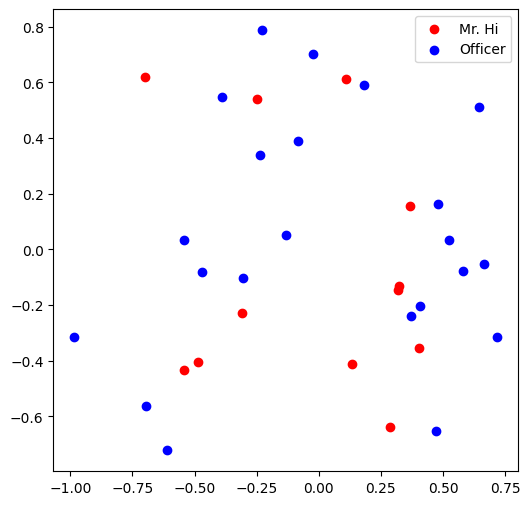

In [57]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []

  ############# Your code here ############
  ## Note:
  ## 1: You need to visualize each node's club (i.e. "Mr. Hi" or "Officer")
  #########################################
  for i in range(len(components)):
    if data.y[i] == 1:
      club1_x.append(components[i][0])
      club1_y.append(components[i][1])
    else:
      club2_x.append(components[i][0])
      club2_y.append(components[i][1])

  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

**Question 9: Training the embedding! What is the best performance you can get? Please report both the best loss and accuracy on Gradescope.**

We want to optimize our embeddings for the task of classifying edges as positive or negative. Given an edge and the embeddings for each node, the dot product of the embeddings, followed by a sigmoid, should give us the likelihood of that edge being either positive (output of sigmoid > 0.5) or negative (output of sigmoid < 0.5).

Note that we're using the functions you wrote in the previous questions, _as well as the variables initialized in previous cells_. If you're running into issues, make sure your answers to questions 1-6 are correct.

In [58]:
from torch.optim import SGD
import torch.nn as nn

def accuracy(pred, label):
  # TODO: Implement the accuracy function. This function takes the
  # pred tensor (the resulting tensor after sigmoid) and the label
  # tensor (torch.LongTensor). Predicted value greater than 0.5 will
  # be classified as label 1. Else it will be classified as label 0.
  # The returned accuracy should be rounded to 4 decimal places.
  # For example, accuracy 0.82956 will be rounded to 0.8296.

  pred = torch.where(pred > 0.5, 1, 0)
  accu = torch.mean(torch.where(pred == label, 1, 0).float())
  accu = round(accu.item(), 4)
  print("Accuracy: {}".format(accu))


  ############# Your code here ############
  #########################################

  return accu

def train(emb, loss_fn, sigmoid, train_label, train_edge):
  # TODO: Train the embedding layer here. You can also change epochs and
  # learning rate. In general, you need to implement:
  # (1) Get the embeddings of the nodes in train_edge
  # (2) Dot product the embeddings between each node pair
  # (3) Feed the dot product result into sigmoid
  # (4) Feed the sigmoid output into the loss_fn
  # (5) Print both loss and accuracy of each epoch
  # (6) Update the embeddings using the loss and optimizer
  # (as a sanity check, the loss should decrease during training)

  epochs = 500
  learning_rate = 0.1

  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):
    optimizer.zero_grad()

    node_emb = emb(train_edge)
    dot_product = torch.sum(node_emb[0] * node_emb[1], dim=1)
    pred = sigmoid(dot_product)
    loss = loss_fn(pred, train_label)
    loss.backward()
    optimizer.step()

    pred = sigmoid(dot_product)
    accuracy_train = accuracy(pred, train_label)
    accuracy_val = accuracy(pred, train_label)
    print("Epoch: {}, Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Accuracy: {:.4f}".format(i, loss.item(), accuracy_train, accuracy_val))


    ############# Your code here ############
    #########################################

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

print(pos_edge_index.shape)

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)
print(train_edge.shape)

train(emb, loss_fn, sigmoid, train_label, train_edge)

torch.Size([2, 78])
torch.Size([2, 156])
Accuracy: 0.5
Accuracy: 0.5
Epoch: 0, Loss: 2.0670, Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Accuracy: 0.5
Accuracy: 0.5
Epoch: 1, Loss: 2.0530, Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Accuracy: 0.5
Accuracy: 0.5
Epoch: 2, Loss: 2.0265, Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Accuracy: 0.5
Accuracy: 0.5
Epoch: 3, Loss: 1.9893, Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Accuracy: 0.5
Accuracy: 0.5
Epoch: 4, Loss: 1.9429, Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Accuracy: 0.5
Accuracy: 0.5
Epoch: 5, Loss: 1.8888, Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Accuracy: 0.5
Accuracy: 0.5
Epoch: 6, Loss: 1.8286, Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Accuracy: 0.5
Accuracy: 0.5
Epoch: 7, Loss: 1.7636, Training Accuracy: 0.5000, Validation Accuracy: 0.5000
Accuracy: 0.5
Accuracy: 0.5
Epoch: 8, Loss: 1.6951, Training Accuracy: 0.5000, Validation Accuracy: 0.5

#### Visualize the final node embeddings
Visualize your final embedding here!
You can visually compare the figure with the previous embedding figure.
After training, you should observe that the two classes are more evidently separated.
This is a great sanitity check for your implementation as well.

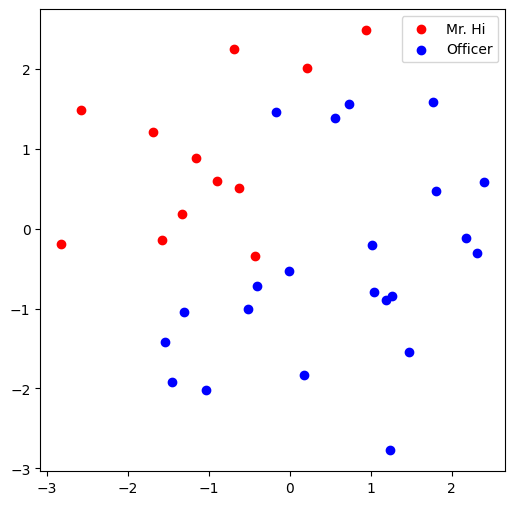

In [59]:
# Visualize the final learned embedding
visualize_emb(emb)

### Implementing Graph Neural Networks (GNNs)

After learning about PyG's data handling, it's time to implement our first Graph Neural Network!

For this, we will use one of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)).

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

#### What is the output of a GNN?

The goal of a GNN is to take an input graph $G = (\mathbb{V}, \mathbb{E})$ where each node $v_i \in \mathbb{V}$ has an input feature vector $X_i^{(0)}$. What we want to learn is a function $f \to \mathbb{V} \times \mathbb{R}^d$, a function that takes in a node and its feature vector, as well as the graph structure, and outputs an _embedding_, a vector that represents that node in a way that's useful to our downstream task. Once we've mapped nodes and their initial features to their learned embeddings, we can use those embeddings to do a variety of different tasks including node-level, edge-level, or graph-level regression/classification.

In this colab, we want to learn embeddings that will be useful to classify each node into its community.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [60]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **three graph convolution layers**. Each layer corresponds to aggregating information from each node's 1-hop neighborhood (its direct neighbors), but when we compose the layers together, we are able to aggregate information from each node's 3-hop neighborhood (all nodes up to 3 "hops" away).

In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.

Embedding shape: [34, 2]


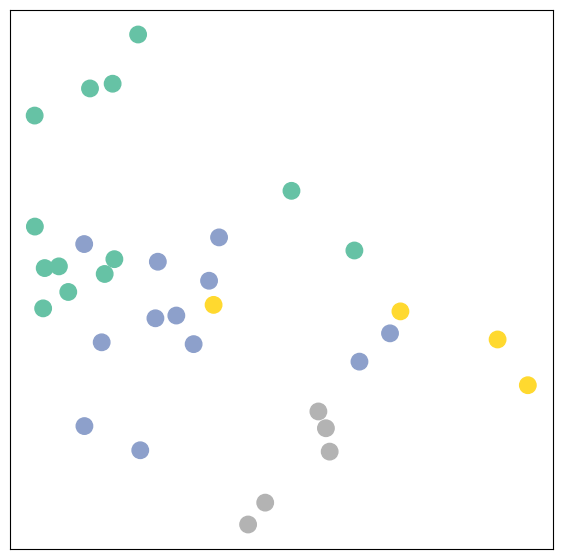

In [61]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

#### Exercise 4

**Question 10: Training GCN on the Karate Club Network! What is the best performance you can receive? Please report both the best loss and accur on gradescope.**

But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observe how the embeddings react.
Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.
If you are not new to PyTorch, this scheme should appear familar to you.
Otherwise, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

<IPython.core.display.Javascript object>

Epoch: 000, Loss: 1.4324, Train Acc: 0.2500, Val Acc: 0.3529


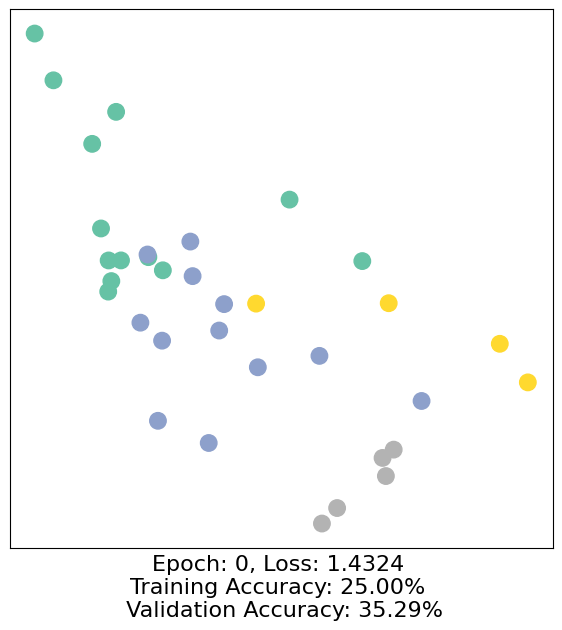

Epoch: 001, Loss: 1.4261, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 002, Loss: 1.4195, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 003, Loss: 1.4126, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 004, Loss: 1.4053, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 005, Loss: 1.3977, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 006, Loss: 1.3898, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 007, Loss: 1.3816, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 008, Loss: 1.3731, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 009, Loss: 1.3642, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 010, Loss: 1.3547, Train Acc: 0.2500, Val Acc: 0.3529


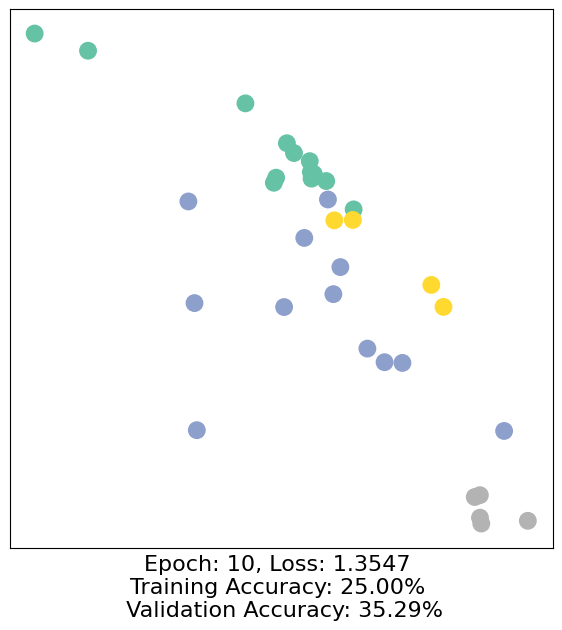

Epoch: 011, Loss: 1.3445, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 012, Loss: 1.3333, Train Acc: 0.2500, Val Acc: 0.3529
Epoch: 013, Loss: 1.3209, Train Acc: 0.2500, Val Acc: 0.4118
Epoch: 014, Loss: 1.3072, Train Acc: 0.2500, Val Acc: 0.4118
Epoch: 015, Loss: 1.2923, Train Acc: 0.2500, Val Acc: 0.4412
Epoch: 016, Loss: 1.2763, Train Acc: 0.2500, Val Acc: 0.5000
Epoch: 017, Loss: 1.2595, Train Acc: 0.2500, Val Acc: 0.6176
Epoch: 018, Loss: 1.2422, Train Acc: 0.2500, Val Acc: 0.6471
Epoch: 019, Loss: 1.2246, Train Acc: 0.2500, Val Acc: 0.6765
Epoch: 020, Loss: 1.2063, Train Acc: 0.5000, Val Acc: 0.6765


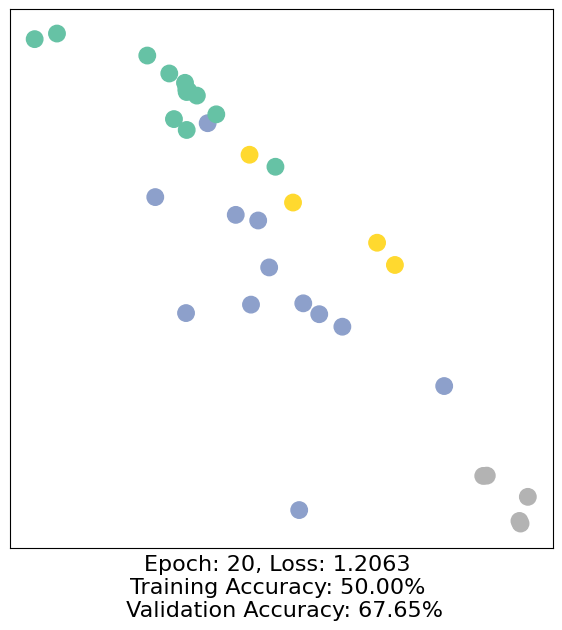

Epoch: 021, Loss: 1.1870, Train Acc: 0.5000, Val Acc: 0.7941
Epoch: 022, Loss: 1.1665, Train Acc: 0.5000, Val Acc: 0.7647
Epoch: 023, Loss: 1.1449, Train Acc: 0.5000, Val Acc: 0.8235
Epoch: 024, Loss: 1.1226, Train Acc: 0.7500, Val Acc: 0.8235
Epoch: 025, Loss: 1.1000, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 026, Loss: 1.0773, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 027, Loss: 1.0547, Train Acc: 1.0000, Val Acc: 0.7647
Epoch: 028, Loss: 1.0317, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 029, Loss: 1.0083, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 030, Loss: 0.9844, Train Acc: 1.0000, Val Acc: 0.7353


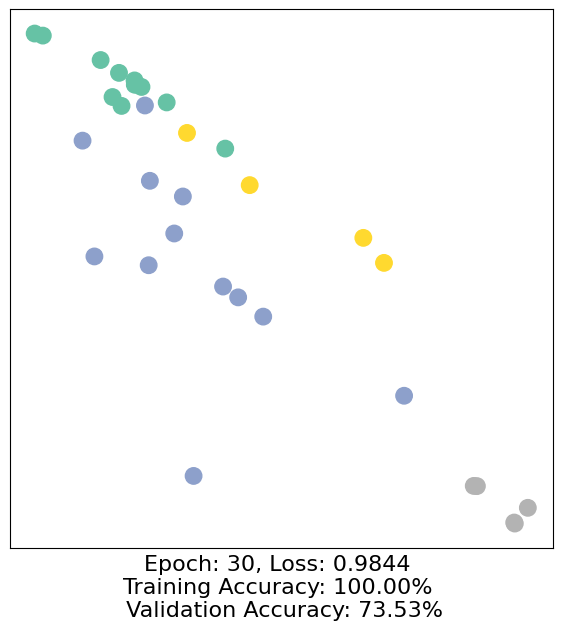

Epoch: 031, Loss: 0.9607, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 032, Loss: 0.9374, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 033, Loss: 0.9145, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 034, Loss: 0.8917, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 035, Loss: 0.8688, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 036, Loss: 0.8460, Train Acc: 1.0000, Val Acc: 0.6765
Epoch: 037, Loss: 0.8238, Train Acc: 1.0000, Val Acc: 0.6765
Epoch: 038, Loss: 0.8021, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 039, Loss: 0.7806, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 040, Loss: 0.7593, Train Acc: 1.0000, Val Acc: 0.6471


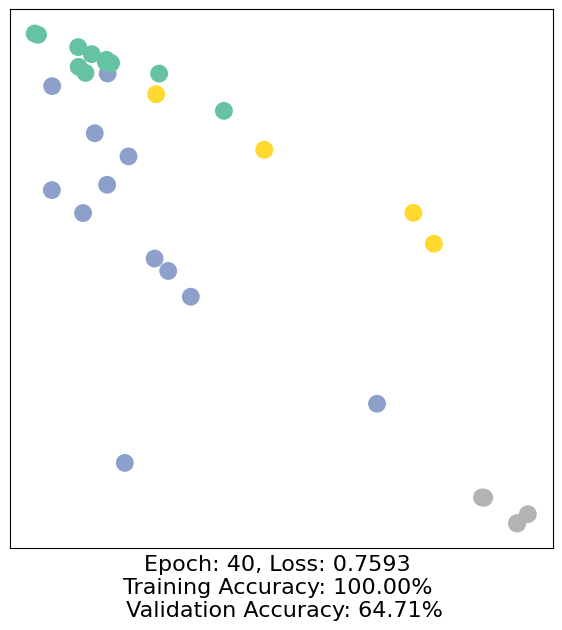

Epoch: 041, Loss: 0.7381, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 042, Loss: 0.7173, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 043, Loss: 0.6968, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 044, Loss: 0.6766, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 045, Loss: 0.6566, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 046, Loss: 0.6369, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 047, Loss: 0.6178, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 048, Loss: 0.5991, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 049, Loss: 0.5809, Train Acc: 1.0000, Val Acc: 0.6471
Epoch: 050, Loss: 0.5632, Train Acc: 1.0000, Val Acc: 0.6765


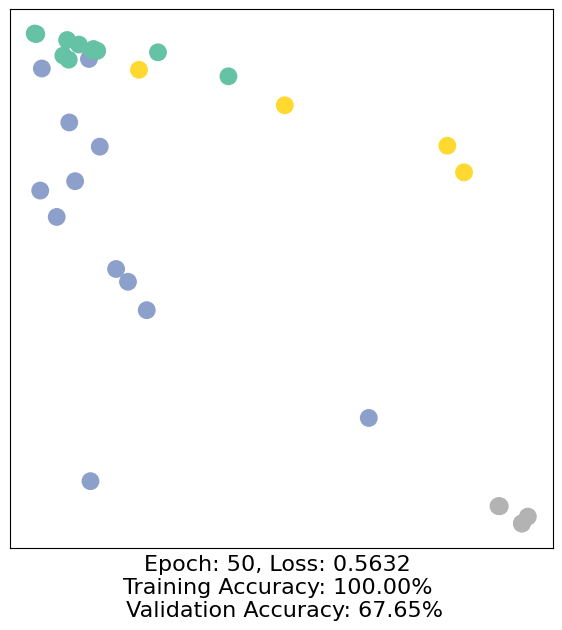

Epoch: 051, Loss: 0.5460, Train Acc: 1.0000, Val Acc: 0.6765
Epoch: 052, Loss: 0.5293, Train Acc: 1.0000, Val Acc: 0.6765
Epoch: 053, Loss: 0.5133, Train Acc: 1.0000, Val Acc: 0.6765
Epoch: 054, Loss: 0.4977, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 055, Loss: 0.4827, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 056, Loss: 0.4683, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 057, Loss: 0.4544, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 058, Loss: 0.4411, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 059, Loss: 0.4284, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 060, Loss: 0.4161, Train Acc: 1.0000, Val Acc: 0.7353


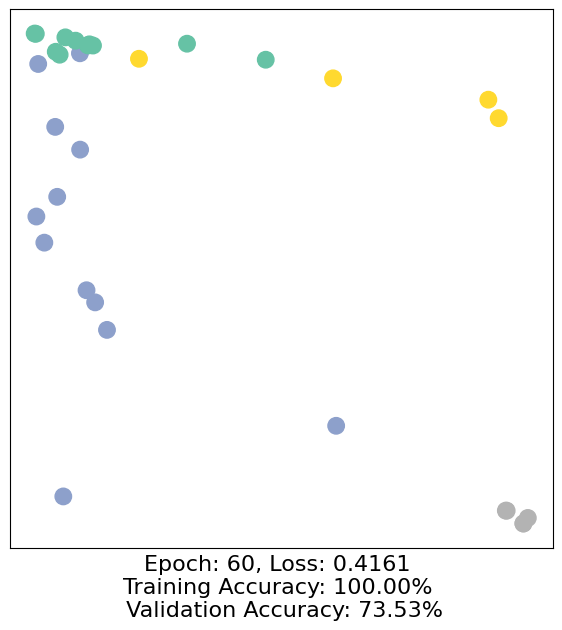

Epoch: 061, Loss: 0.4044, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 062, Loss: 0.3931, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 063, Loss: 0.3824, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 064, Loss: 0.3721, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 065, Loss: 0.3622, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 066, Loss: 0.3528, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 067, Loss: 0.3437, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 068, Loss: 0.3351, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 069, Loss: 0.3268, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 070, Loss: 0.3188, Train Acc: 1.0000, Val Acc: 0.7353


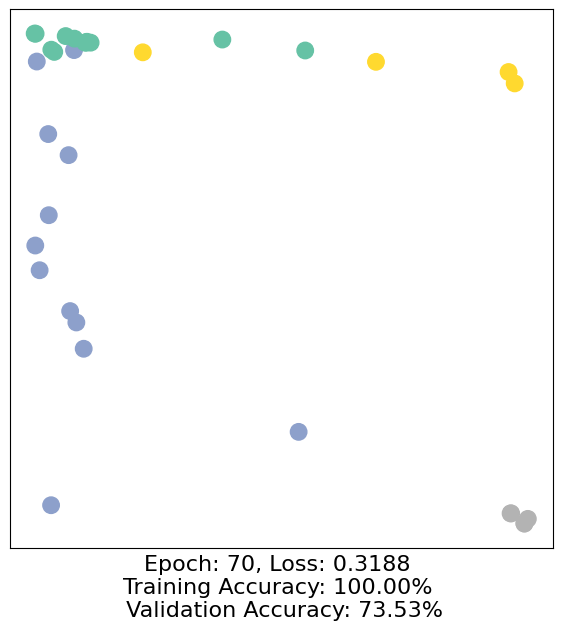

Epoch: 071, Loss: 0.3112, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 072, Loss: 0.3038, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 073, Loss: 0.2968, Train Acc: 1.0000, Val Acc: 0.7059
Epoch: 074, Loss: 0.2901, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 075, Loss: 0.2836, Train Acc: 1.0000, Val Acc: 0.7353
Epoch: 076, Loss: 0.2774, Train Acc: 1.0000, Val Acc: 0.7647
Epoch: 077, Loss: 0.2714, Train Acc: 1.0000, Val Acc: 0.7647
Epoch: 078, Loss: 0.2657, Train Acc: 1.0000, Val Acc: 0.7647
Epoch: 079, Loss: 0.2601, Train Acc: 1.0000, Val Acc: 0.7647
Epoch: 080, Loss: 0.2548, Train Acc: 1.0000, Val Acc: 0.7647


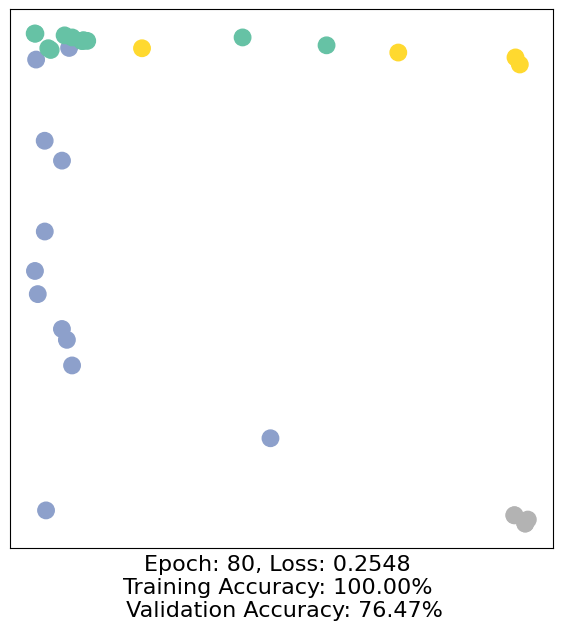

Epoch: 081, Loss: 0.2497, Train Acc: 1.0000, Val Acc: 0.7647
Epoch: 082, Loss: 0.2448, Train Acc: 1.0000, Val Acc: 0.7647
Epoch: 083, Loss: 0.2400, Train Acc: 1.0000, Val Acc: 0.7647
Epoch: 084, Loss: 0.2354, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 085, Loss: 0.2310, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 086, Loss: 0.2267, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 087, Loss: 0.2226, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 088, Loss: 0.2186, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 089, Loss: 0.2148, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 090, Loss: 0.2110, Train Acc: 1.0000, Val Acc: 0.7941


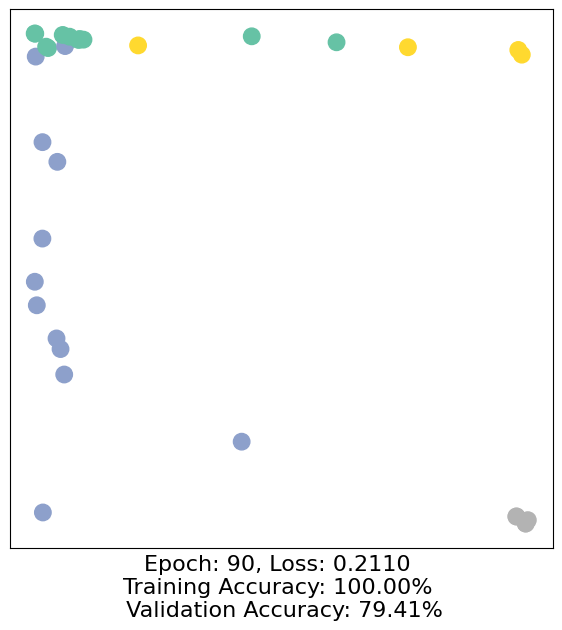

Epoch: 091, Loss: 0.2074, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 092, Loss: 0.2039, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 093, Loss: 0.2006, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 094, Loss: 0.1973, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 095, Loss: 0.1941, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 096, Loss: 0.1910, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 097, Loss: 0.1880, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 098, Loss: 0.1851, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 099, Loss: 0.1823, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 100, Loss: 0.1795, Train Acc: 1.0000, Val Acc: 0.7941


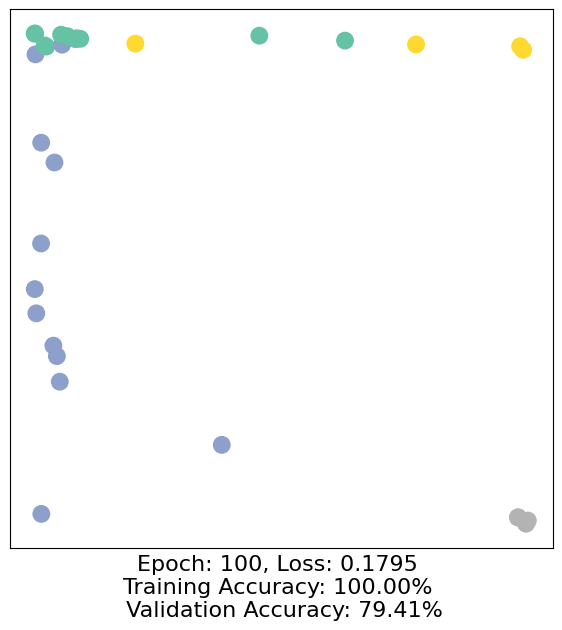

Epoch: 101, Loss: 0.1769, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 102, Loss: 0.1743, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 103, Loss: 0.1717, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 104, Loss: 0.1693, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 105, Loss: 0.1669, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 106, Loss: 0.1645, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 107, Loss: 0.1623, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 108, Loss: 0.1601, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 109, Loss: 0.1579, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 110, Loss: 0.1558, Train Acc: 1.0000, Val Acc: 0.7941


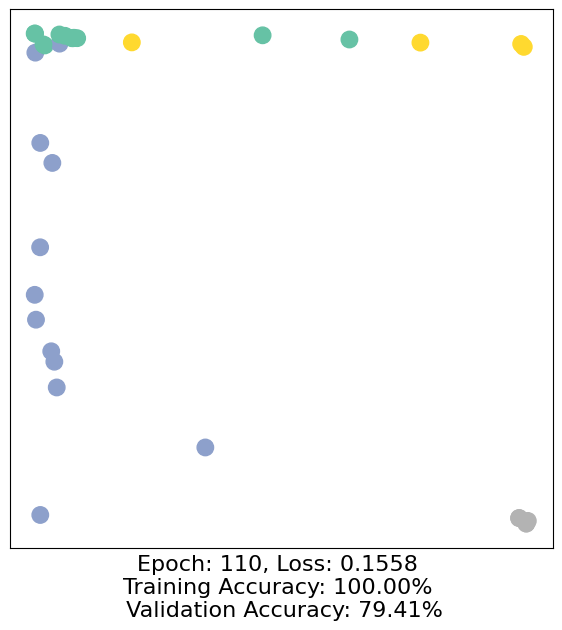

Epoch: 111, Loss: 0.1537, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 112, Loss: 0.1517, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 113, Loss: 0.1498, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 114, Loss: 0.1479, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 115, Loss: 0.1460, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 116, Loss: 0.1442, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 117, Loss: 0.1424, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 118, Loss: 0.1406, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 119, Loss: 0.1389, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 120, Loss: 0.1373, Train Acc: 1.0000, Val Acc: 0.7941


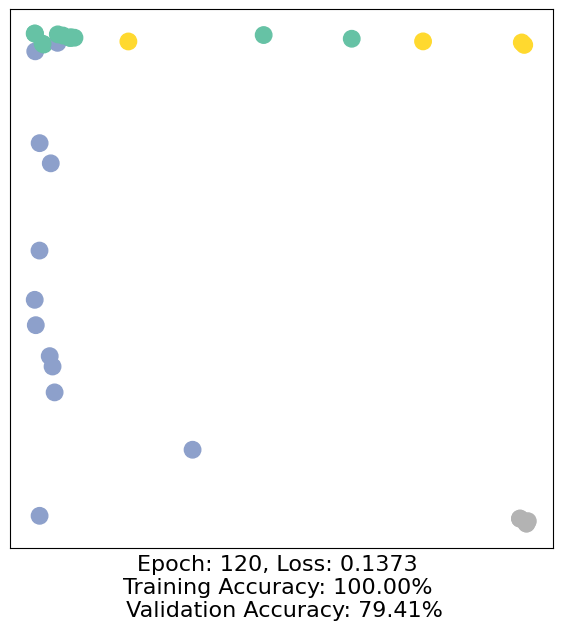

Epoch: 121, Loss: 0.1356, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 122, Loss: 0.1340, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 123, Loss: 0.1325, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 124, Loss: 0.1309, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 125, Loss: 0.1294, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 126, Loss: 0.1280, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 127, Loss: 0.1265, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 128, Loss: 0.1251, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 129, Loss: 0.1237, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 130, Loss: 0.1224, Train Acc: 1.0000, Val Acc: 0.7941


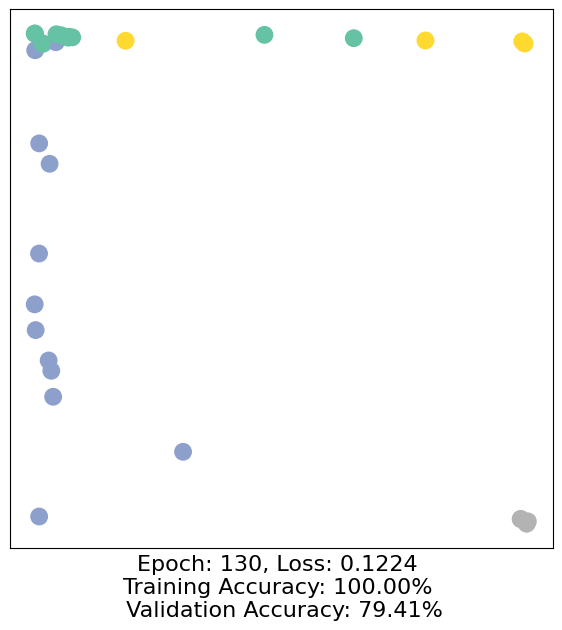

Epoch: 131, Loss: 0.1211, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 132, Loss: 0.1197, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 133, Loss: 0.1185, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 134, Loss: 0.1172, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 135, Loss: 0.1160, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 136, Loss: 0.1148, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 137, Loss: 0.1136, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 138, Loss: 0.1124, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 139, Loss: 0.1113, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 140, Loss: 0.1102, Train Acc: 1.0000, Val Acc: 0.7941


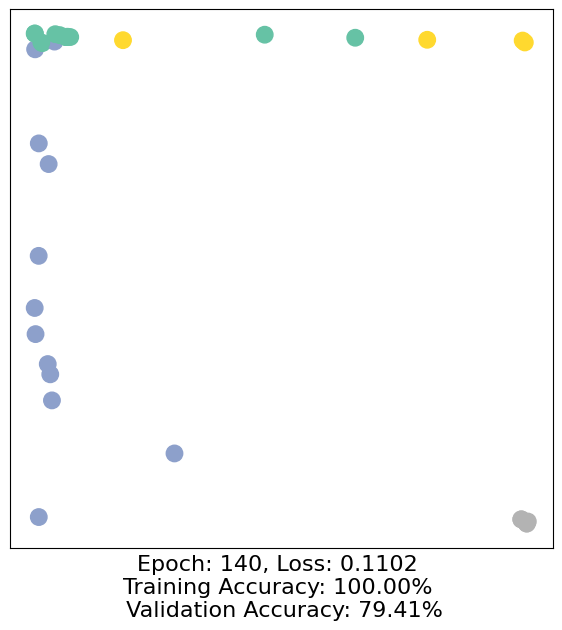

Epoch: 141, Loss: 0.1091, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 142, Loss: 0.1080, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 143, Loss: 0.1069, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 144, Loss: 0.1059, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 145, Loss: 0.1048, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 146, Loss: 0.1038, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 147, Loss: 0.1028, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 148, Loss: 0.1018, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 149, Loss: 0.1009, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 150, Loss: 0.0999, Train Acc: 1.0000, Val Acc: 0.7941


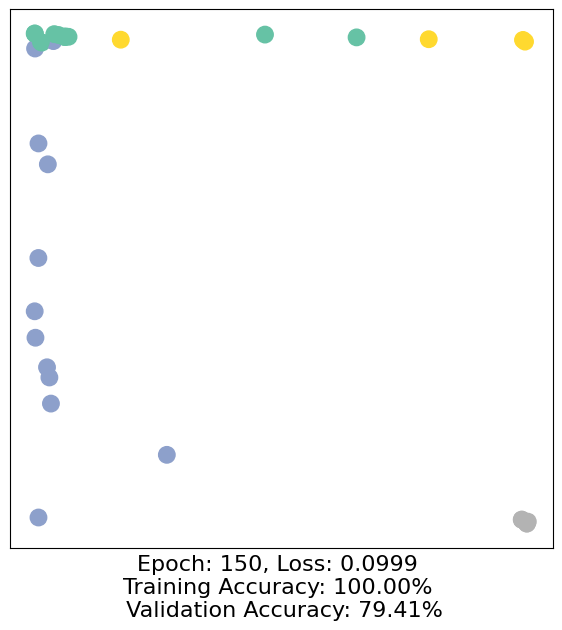

Epoch: 151, Loss: 0.0990, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 152, Loss: 0.0981, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 153, Loss: 0.0972, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 154, Loss: 0.0963, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 155, Loss: 0.0954, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 156, Loss: 0.0946, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 157, Loss: 0.0937, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 158, Loss: 0.0929, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 159, Loss: 0.0921, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 160, Loss: 0.0913, Train Acc: 1.0000, Val Acc: 0.7941


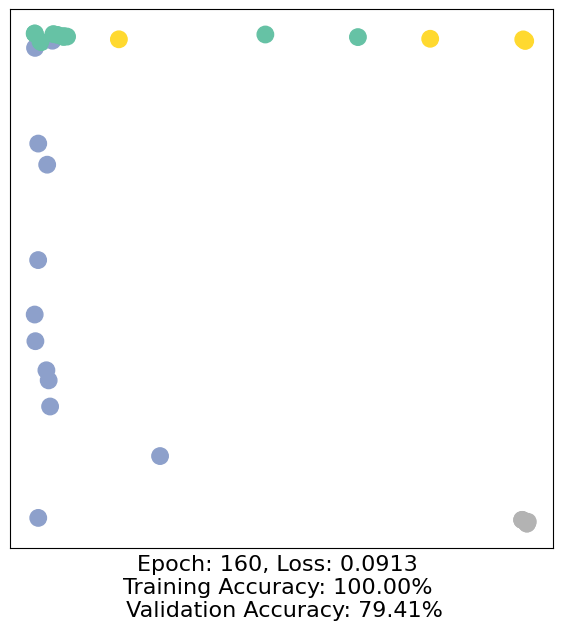

Epoch: 161, Loss: 0.0905, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 162, Loss: 0.0897, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 163, Loss: 0.0889, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 164, Loss: 0.0881, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 165, Loss: 0.0874, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 166, Loss: 0.0866, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 167, Loss: 0.0859, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 168, Loss: 0.0852, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 169, Loss: 0.0845, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 170, Loss: 0.0838, Train Acc: 1.0000, Val Acc: 0.7941


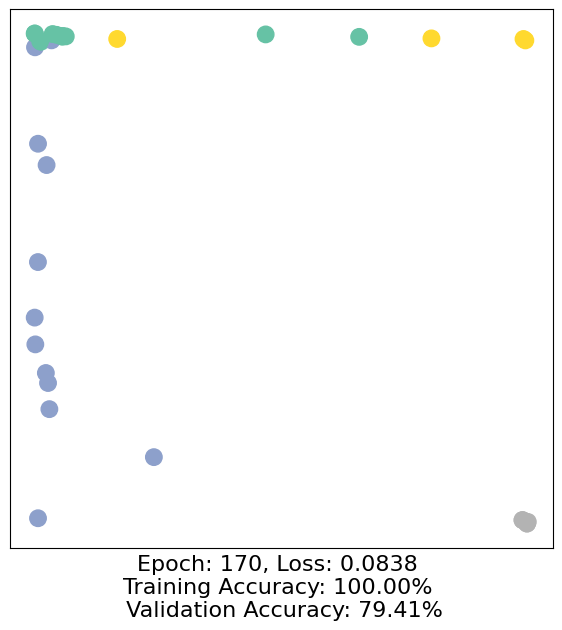

Epoch: 171, Loss: 0.0831, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 172, Loss: 0.0824, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 173, Loss: 0.0818, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 174, Loss: 0.0811, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 175, Loss: 0.0805, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 176, Loss: 0.0798, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 177, Loss: 0.0792, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 178, Loss: 0.0786, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 179, Loss: 0.0779, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 180, Loss: 0.0773, Train Acc: 1.0000, Val Acc: 0.7941


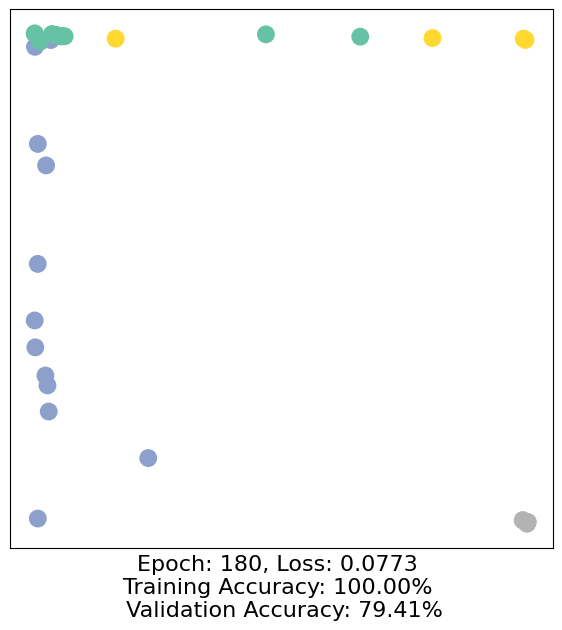

Epoch: 181, Loss: 0.0767, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 182, Loss: 0.0761, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 183, Loss: 0.0755, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 184, Loss: 0.0750, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 185, Loss: 0.0744, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 186, Loss: 0.0738, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 187, Loss: 0.0733, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 188, Loss: 0.0727, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 189, Loss: 0.0722, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 190, Loss: 0.0717, Train Acc: 1.0000, Val Acc: 0.7941


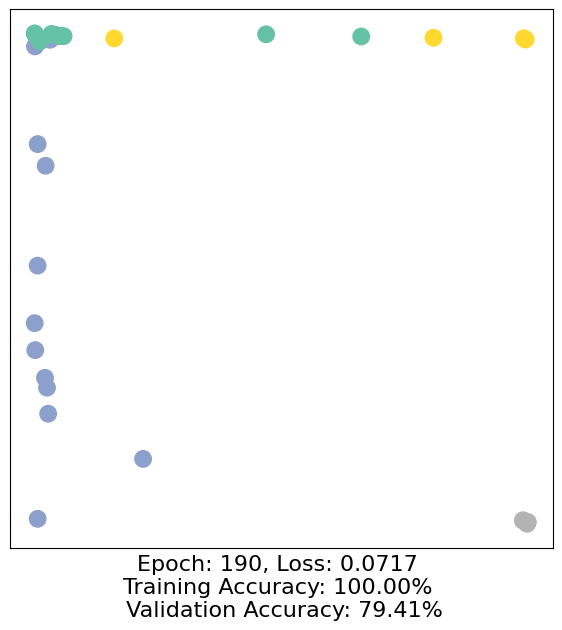

Epoch: 191, Loss: 0.0711, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 192, Loss: 0.0706, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 193, Loss: 0.0701, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 194, Loss: 0.0696, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 195, Loss: 0.0691, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 196, Loss: 0.0686, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 197, Loss: 0.0681, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 198, Loss: 0.0676, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 199, Loss: 0.0671, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 200, Loss: 0.0667, Train Acc: 1.0000, Val Acc: 0.7941


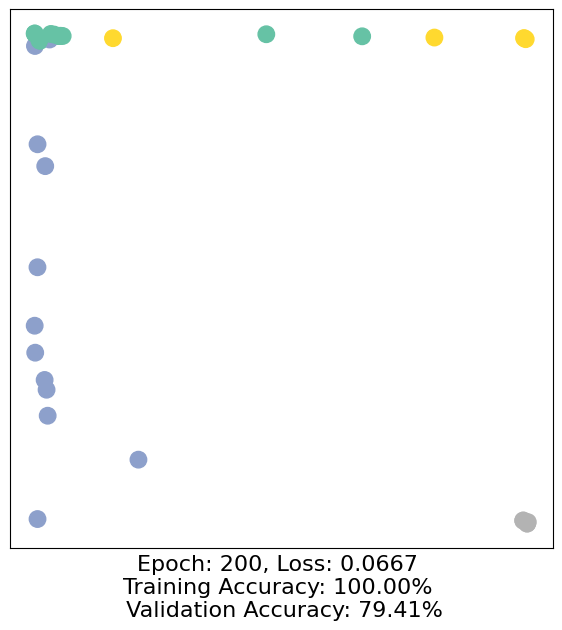

Epoch: 201, Loss: 0.0662, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 202, Loss: 0.0657, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 203, Loss: 0.0653, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 204, Loss: 0.0648, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 205, Loss: 0.0644, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 206, Loss: 0.0639, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 207, Loss: 0.0635, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 208, Loss: 0.0631, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 209, Loss: 0.0627, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 210, Loss: 0.0622, Train Acc: 1.0000, Val Acc: 0.7941


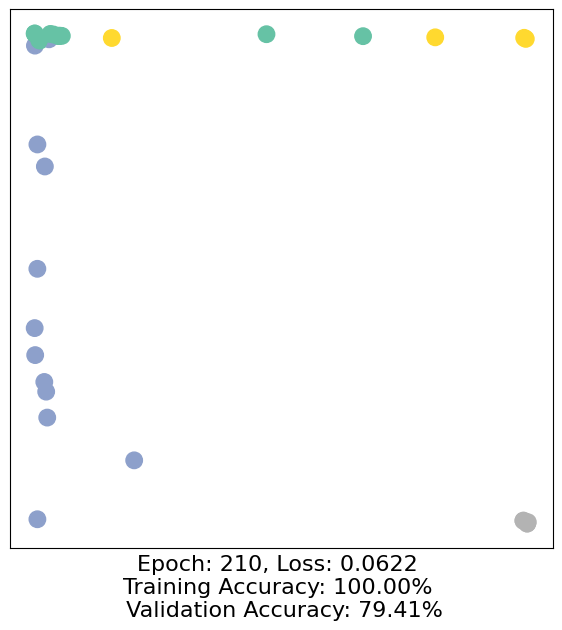

Epoch: 211, Loss: 0.0618, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 212, Loss: 0.0614, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 213, Loss: 0.0610, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 214, Loss: 0.0606, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 215, Loss: 0.0602, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 216, Loss: 0.0598, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 217, Loss: 0.0594, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 218, Loss: 0.0590, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 219, Loss: 0.0586, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 220, Loss: 0.0583, Train Acc: 1.0000, Val Acc: 0.7941


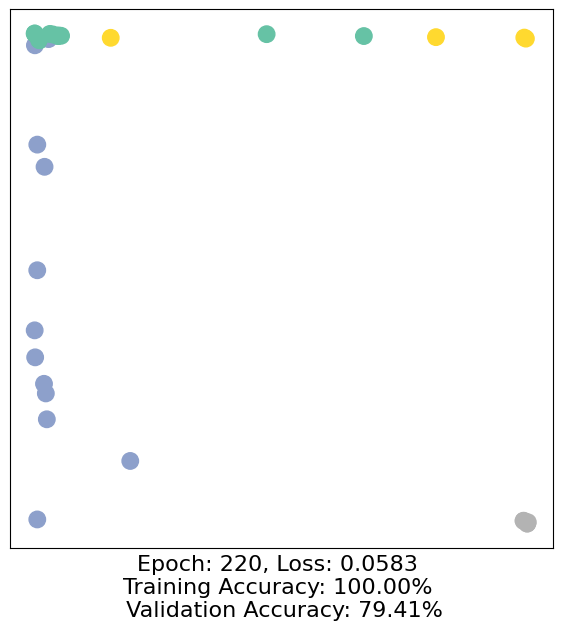

Epoch: 221, Loss: 0.0579, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 222, Loss: 0.0575, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 223, Loss: 0.0572, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 224, Loss: 0.0568, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 225, Loss: 0.0564, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 226, Loss: 0.0561, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 227, Loss: 0.0557, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 228, Loss: 0.0554, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 229, Loss: 0.0550, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 230, Loss: 0.0547, Train Acc: 1.0000, Val Acc: 0.7941


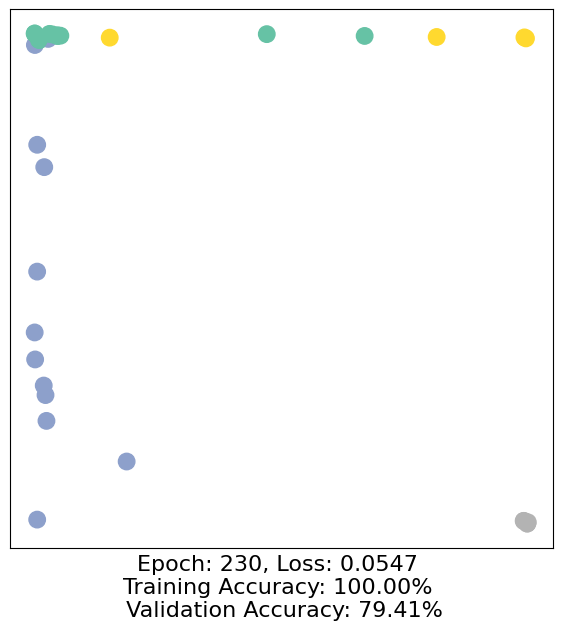

Epoch: 231, Loss: 0.0544, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 232, Loss: 0.0540, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 233, Loss: 0.0537, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 234, Loss: 0.0534, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 235, Loss: 0.0531, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 236, Loss: 0.0527, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 237, Loss: 0.0524, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 238, Loss: 0.0521, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 239, Loss: 0.0518, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 240, Loss: 0.0515, Train Acc: 1.0000, Val Acc: 0.7941


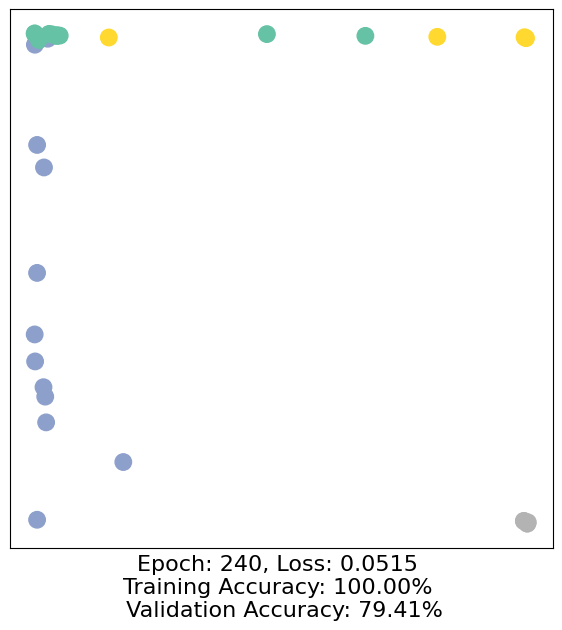

Epoch: 241, Loss: 0.0512, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 242, Loss: 0.0509, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 243, Loss: 0.0506, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 244, Loss: 0.0503, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 245, Loss: 0.0500, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 246, Loss: 0.0497, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 247, Loss: 0.0494, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 248, Loss: 0.0491, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 249, Loss: 0.0489, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 250, Loss: 0.0486, Train Acc: 1.0000, Val Acc: 0.7941


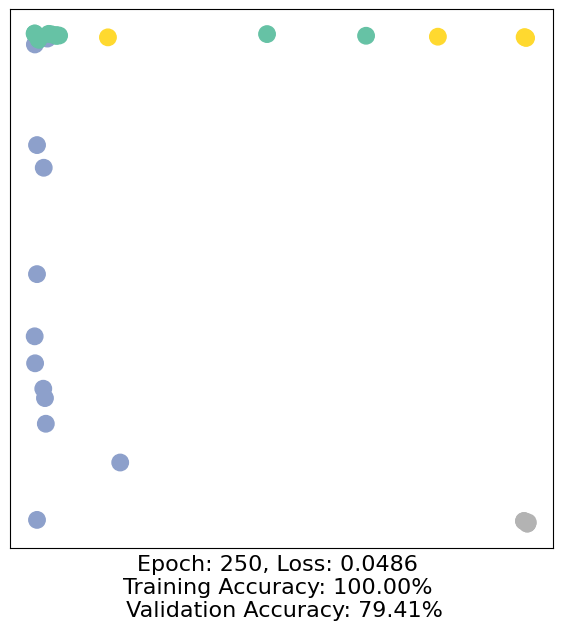

Epoch: 251, Loss: 0.0483, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 252, Loss: 0.0480, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 253, Loss: 0.0478, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 254, Loss: 0.0475, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 255, Loss: 0.0472, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 256, Loss: 0.0470, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 257, Loss: 0.0467, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 258, Loss: 0.0465, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 259, Loss: 0.0462, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 260, Loss: 0.0459, Train Acc: 1.0000, Val Acc: 0.7941


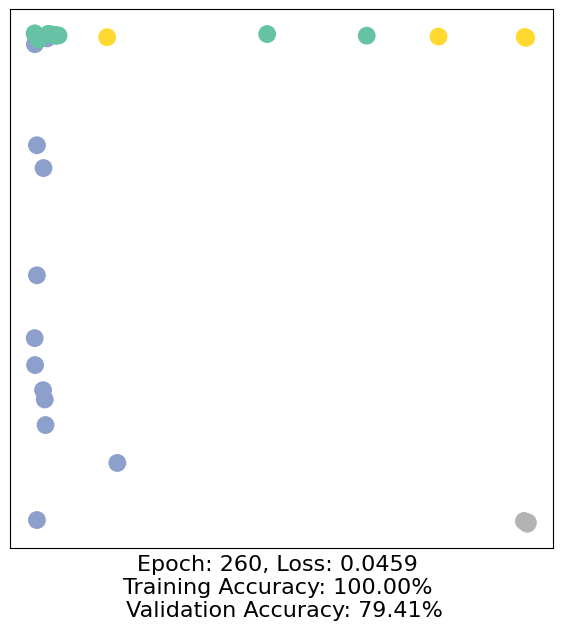

Epoch: 261, Loss: 0.0457, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 262, Loss: 0.0454, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 263, Loss: 0.0452, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 264, Loss: 0.0449, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 265, Loss: 0.0447, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 266, Loss: 0.0445, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 267, Loss: 0.0442, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 268, Loss: 0.0440, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 269, Loss: 0.0438, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 270, Loss: 0.0435, Train Acc: 1.0000, Val Acc: 0.7941


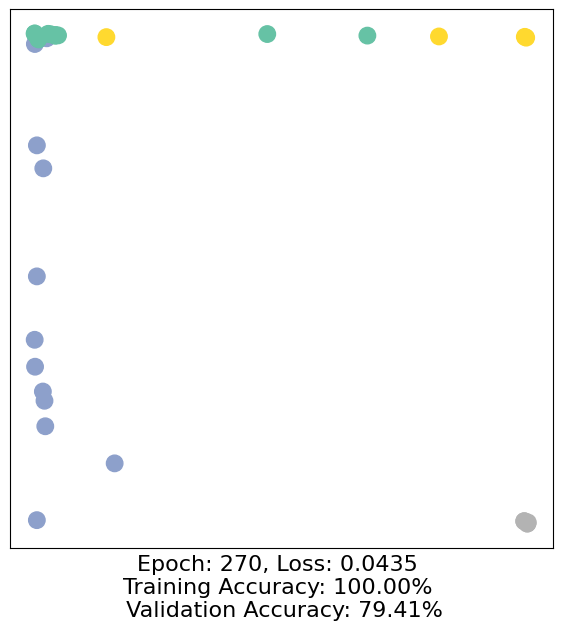

Epoch: 271, Loss: 0.0433, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 272, Loss: 0.0431, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 273, Loss: 0.0428, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 274, Loss: 0.0426, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 275, Loss: 0.0424, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 276, Loss: 0.0422, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 277, Loss: 0.0420, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 278, Loss: 0.0417, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 279, Loss: 0.0415, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 280, Loss: 0.0413, Train Acc: 1.0000, Val Acc: 0.7941


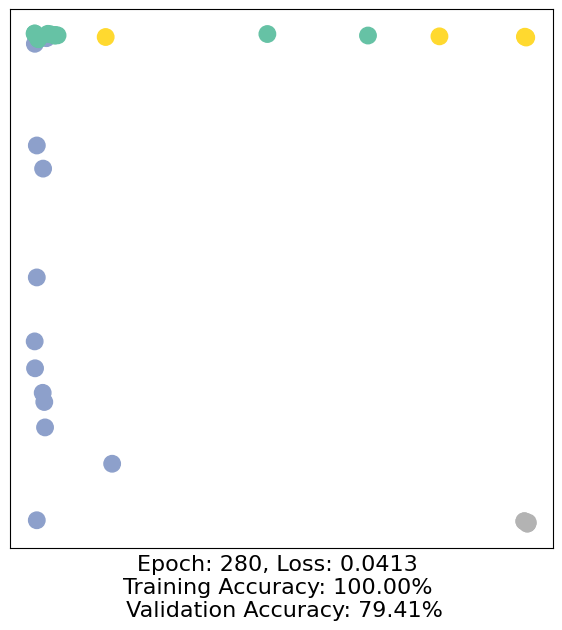

Epoch: 281, Loss: 0.0411, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 282, Loss: 0.0409, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 283, Loss: 0.0407, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 284, Loss: 0.0405, Train Acc: 1.0000, Val Acc: 0.7941
Epoch: 285, Loss: 0.0403, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 286, Loss: 0.0401, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 287, Loss: 0.0399, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 288, Loss: 0.0397, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 289, Loss: 0.0395, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 290, Loss: 0.0393, Train Acc: 1.0000, Val Acc: 0.8235


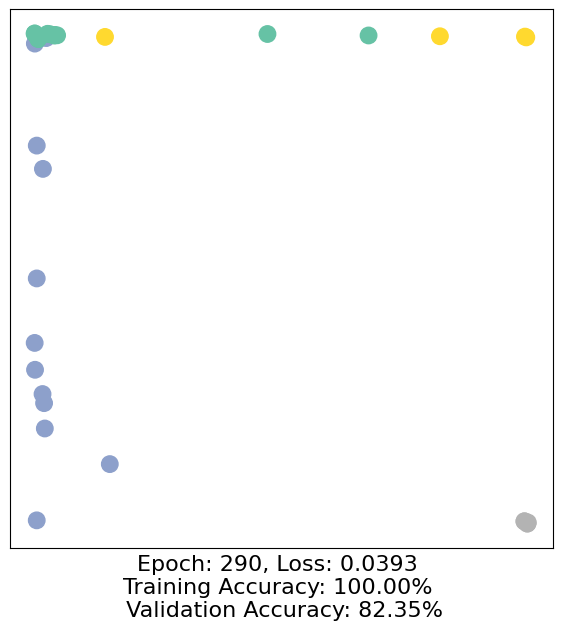

Epoch: 291, Loss: 0.0391, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 292, Loss: 0.0389, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 293, Loss: 0.0387, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 294, Loss: 0.0385, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 295, Loss: 0.0383, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 296, Loss: 0.0381, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 297, Loss: 0.0379, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 298, Loss: 0.0378, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 299, Loss: 0.0376, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 300, Loss: 0.0374, Train Acc: 1.0000, Val Acc: 0.8235


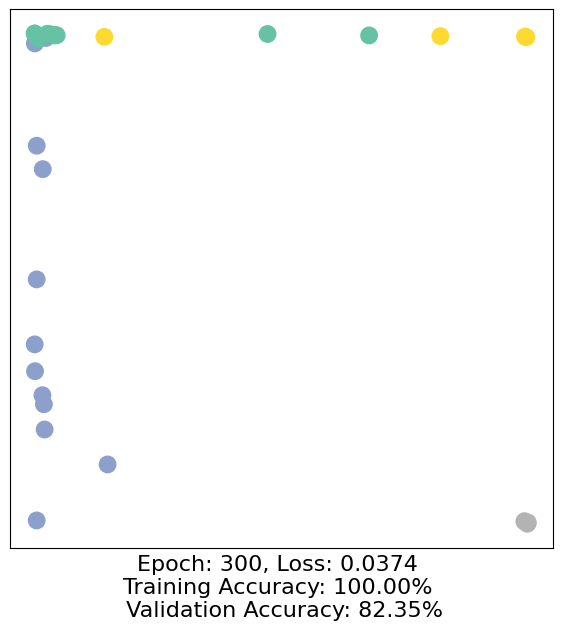

Epoch: 301, Loss: 0.0372, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 302, Loss: 0.0370, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 303, Loss: 0.0369, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 304, Loss: 0.0367, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 305, Loss: 0.0365, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 306, Loss: 0.0363, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 307, Loss: 0.0362, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 308, Loss: 0.0360, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 309, Loss: 0.0358, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 310, Loss: 0.0357, Train Acc: 1.0000, Val Acc: 0.8235


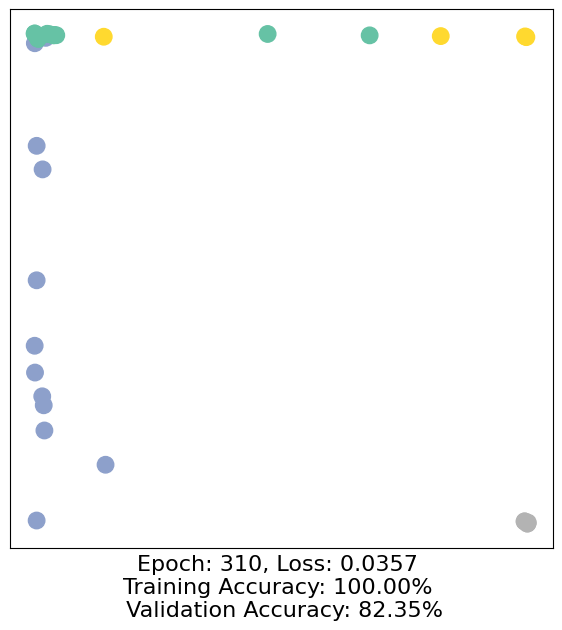

Epoch: 311, Loss: 0.0355, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 312, Loss: 0.0353, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 313, Loss: 0.0352, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 314, Loss: 0.0350, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 315, Loss: 0.0349, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 316, Loss: 0.0347, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 317, Loss: 0.0345, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 318, Loss: 0.0344, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 319, Loss: 0.0342, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 320, Loss: 0.0341, Train Acc: 1.0000, Val Acc: 0.8235


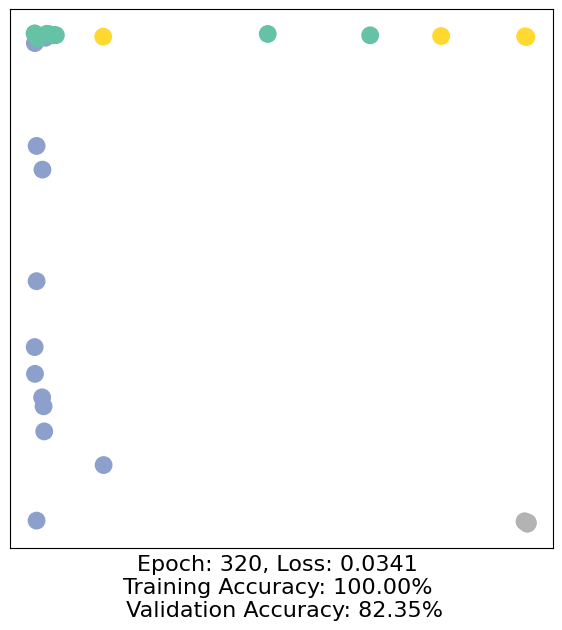

Epoch: 321, Loss: 0.0339, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 322, Loss: 0.0338, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 323, Loss: 0.0336, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 324, Loss: 0.0335, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 325, Loss: 0.0333, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 326, Loss: 0.0332, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 327, Loss: 0.0330, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 328, Loss: 0.0329, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 329, Loss: 0.0327, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 330, Loss: 0.0326, Train Acc: 1.0000, Val Acc: 0.8235


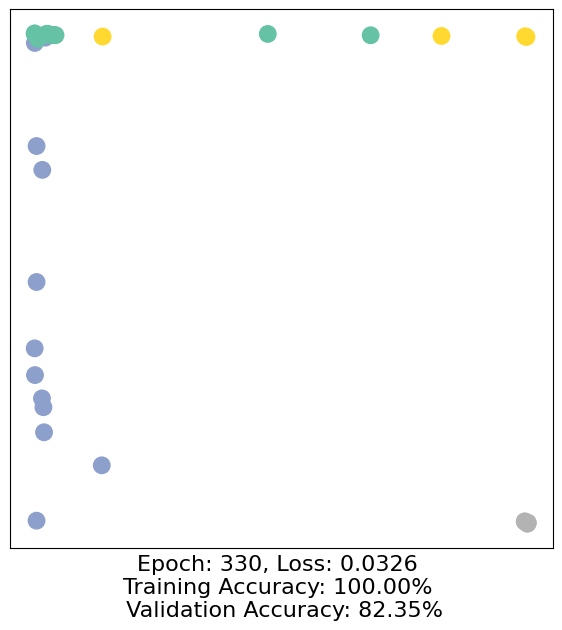

Epoch: 331, Loss: 0.0324, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 332, Loss: 0.0323, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 333, Loss: 0.0321, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 334, Loss: 0.0320, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 335, Loss: 0.0319, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 336, Loss: 0.0317, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 337, Loss: 0.0316, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 338, Loss: 0.0315, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 339, Loss: 0.0313, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 340, Loss: 0.0312, Train Acc: 1.0000, Val Acc: 0.8235


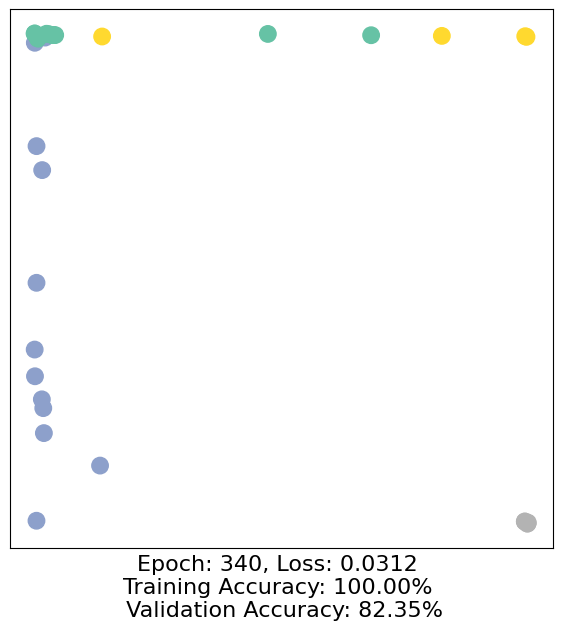

Epoch: 341, Loss: 0.0311, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 342, Loss: 0.0309, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 343, Loss: 0.0308, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 344, Loss: 0.0307, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 345, Loss: 0.0305, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 346, Loss: 0.0304, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 347, Loss: 0.0303, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 348, Loss: 0.0301, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 349, Loss: 0.0300, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 350, Loss: 0.0299, Train Acc: 1.0000, Val Acc: 0.8235


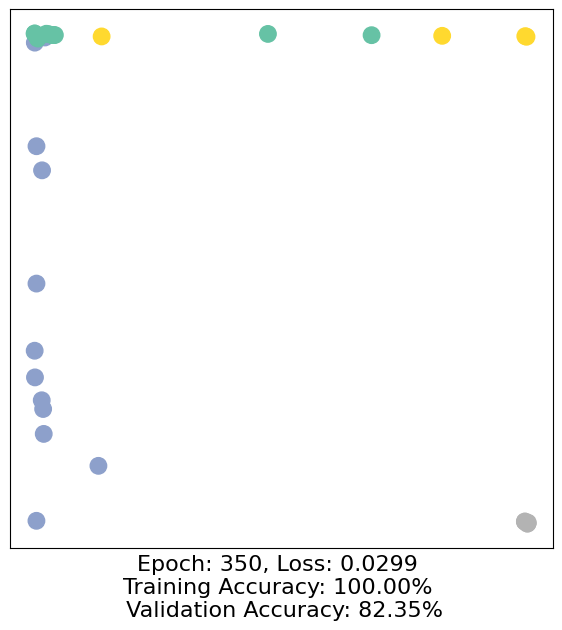

Epoch: 351, Loss: 0.0298, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 352, Loss: 0.0296, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 353, Loss: 0.0295, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 354, Loss: 0.0294, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 355, Loss: 0.0293, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 356, Loss: 0.0292, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 357, Loss: 0.0290, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 358, Loss: 0.0289, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 359, Loss: 0.0288, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 360, Loss: 0.0287, Train Acc: 1.0000, Val Acc: 0.8235


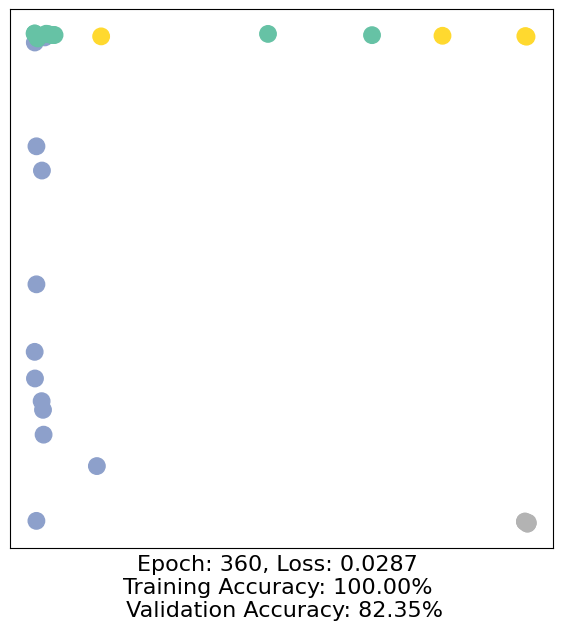

Epoch: 361, Loss: 0.0286, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 362, Loss: 0.0285, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 363, Loss: 0.0283, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 364, Loss: 0.0282, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 365, Loss: 0.0281, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 366, Loss: 0.0280, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 367, Loss: 0.0279, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 368, Loss: 0.0278, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 369, Loss: 0.0277, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 370, Loss: 0.0276, Train Acc: 1.0000, Val Acc: 0.8235


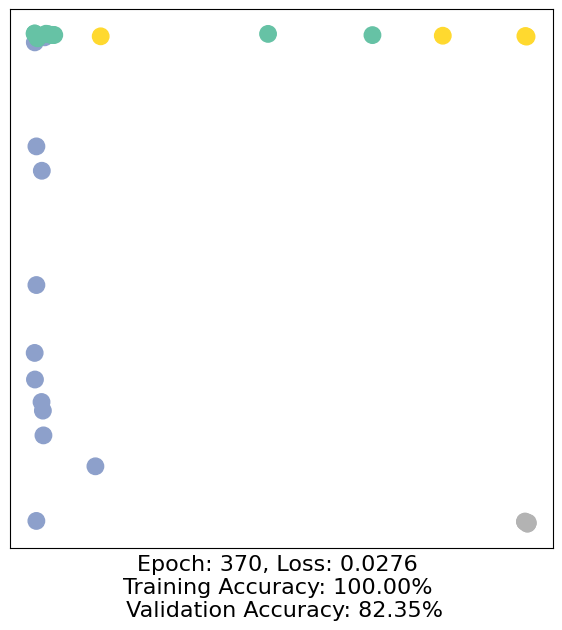

Epoch: 371, Loss: 0.0274, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 372, Loss: 0.0273, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 373, Loss: 0.0272, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 374, Loss: 0.0271, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 375, Loss: 0.0270, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 376, Loss: 0.0269, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 377, Loss: 0.0268, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 378, Loss: 0.0267, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 379, Loss: 0.0266, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 380, Loss: 0.0265, Train Acc: 1.0000, Val Acc: 0.8235


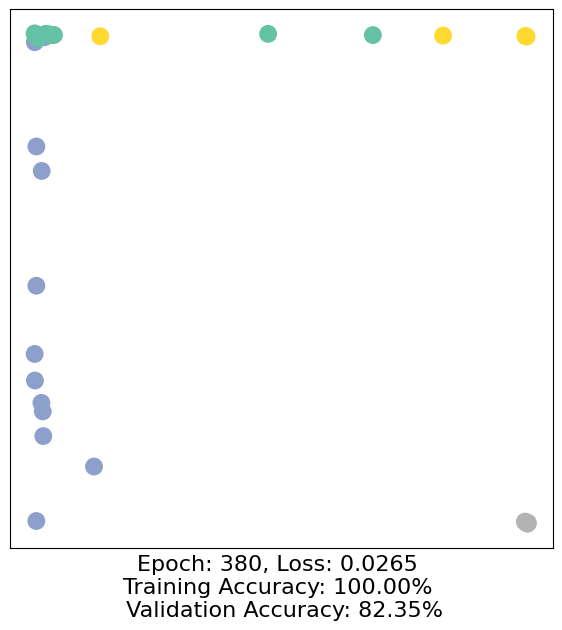

Epoch: 381, Loss: 0.0264, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 382, Loss: 0.0263, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 383, Loss: 0.0262, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 384, Loss: 0.0261, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 385, Loss: 0.0260, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 386, Loss: 0.0259, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 387, Loss: 0.0258, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 388, Loss: 0.0257, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 389, Loss: 0.0256, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 390, Loss: 0.0255, Train Acc: 1.0000, Val Acc: 0.8235


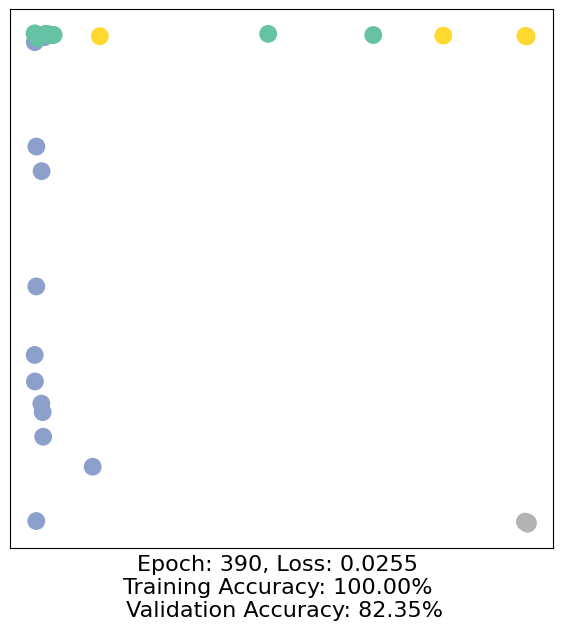

Epoch: 391, Loss: 0.0254, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 392, Loss: 0.0253, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 393, Loss: 0.0252, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 394, Loss: 0.0251, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 395, Loss: 0.0250, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 396, Loss: 0.0249, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 397, Loss: 0.0248, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 398, Loss: 0.0247, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 399, Loss: 0.0247, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 400, Loss: 0.0246, Train Acc: 1.0000, Val Acc: 0.8235


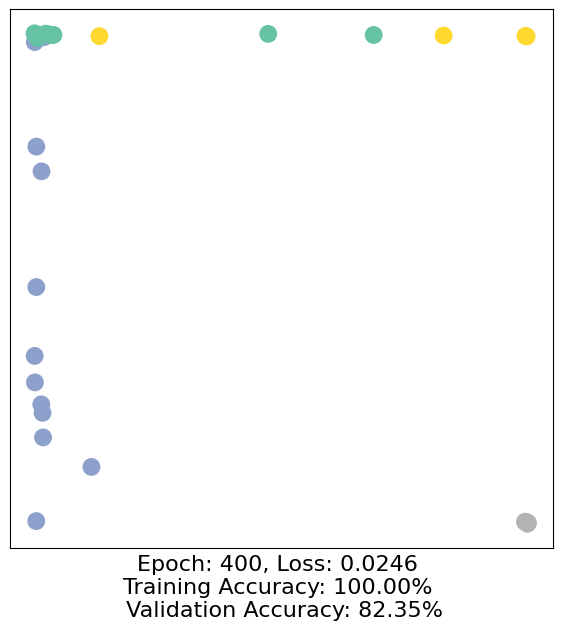

Epoch: 401, Loss: 0.0245, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 402, Loss: 0.0244, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 403, Loss: 0.0243, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 404, Loss: 0.0242, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 405, Loss: 0.0241, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 406, Loss: 0.0240, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 407, Loss: 0.0239, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 408, Loss: 0.0239, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 409, Loss: 0.0238, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 410, Loss: 0.0237, Train Acc: 1.0000, Val Acc: 0.8235


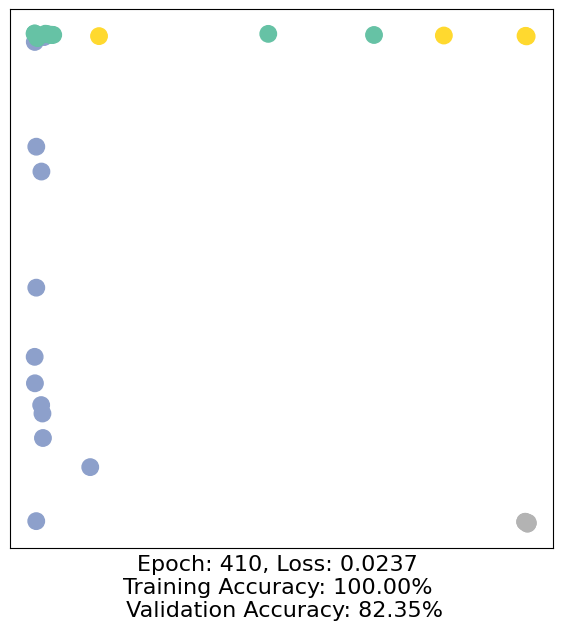

Epoch: 411, Loss: 0.0236, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 412, Loss: 0.0235, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 413, Loss: 0.0234, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 414, Loss: 0.0233, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 415, Loss: 0.0233, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 416, Loss: 0.0232, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 417, Loss: 0.0231, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 418, Loss: 0.0230, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 419, Loss: 0.0229, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 420, Loss: 0.0229, Train Acc: 1.0000, Val Acc: 0.8235


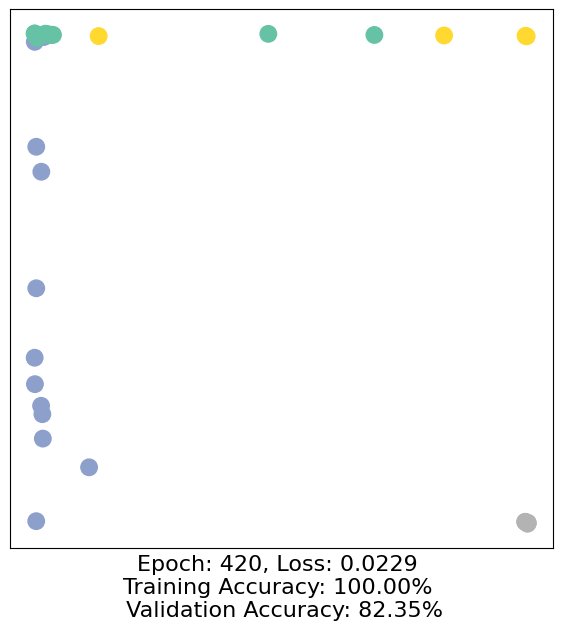

Epoch: 421, Loss: 0.0228, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 422, Loss: 0.0227, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 423, Loss: 0.0226, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 424, Loss: 0.0225, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 425, Loss: 0.0225, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 426, Loss: 0.0224, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 427, Loss: 0.0223, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 428, Loss: 0.0222, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 429, Loss: 0.0221, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 430, Loss: 0.0221, Train Acc: 1.0000, Val Acc: 0.8235


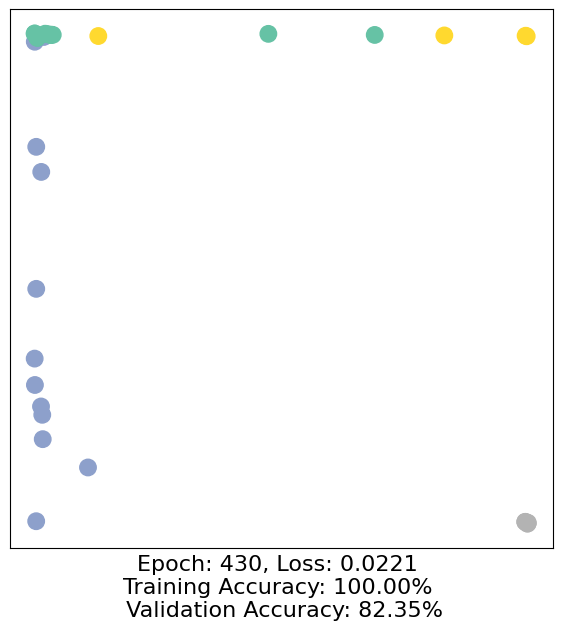

Epoch: 431, Loss: 0.0220, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 432, Loss: 0.0219, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 433, Loss: 0.0218, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 434, Loss: 0.0218, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 435, Loss: 0.0217, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 436, Loss: 0.0216, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 437, Loss: 0.0215, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 438, Loss: 0.0215, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 439, Loss: 0.0214, Train Acc: 1.0000, Val Acc: 0.8235
Epoch: 440, Loss: 0.0213, Train Acc: 1.0000, Val Acc: 0.8235


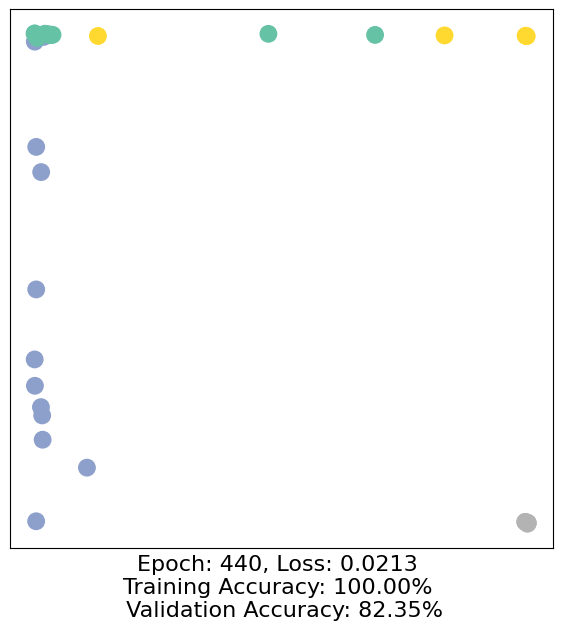

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.

    accuracy = {}

    # Calculate training accuracy on the training nodes
    predicted_classes = torch.argmax(out[data.train_mask], axis=1)  # [0.6, 0.2, 0.7, 0.1] -> 2
    target_classes = data.y[data.train_mask]
    accuracy['train'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    # Calculate validation accuracy on the whole graph
    model.eval()
    out, h = model(data.x, data.edge_index)
    predicted_classes = torch.argmax(out, axis=1)
    target_classes = data.y
    accuracy['val'] = torch.mean(
        torch.where(predicted_classes == target_classes, 1, 0).float())

    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {accuracy['train']:.4f}, Val Acc: {accuracy['val']:.4f}")

    return loss, h, accuracy

for epoch in range(500):
    loss, h, accuracy = train(data)
    # Visualize the node embeddings every 10 epochs
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss, accuracy=accuracy)
        time.sleep(0.3)


As one can see, our 3-layer GCN model manages to separate the communities pretty well and classify most of the nodes correctly.

Furthermore, we did this all with a few lines of code, thanks to the PyTorch Geometric library which helped us out with data handling and GNN implementations.
